# Setup

In [1]:
# basic
import numpy as np
import pandas as pd
import math
import re

# visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import (
    PowerTransformer,
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
)

# modeling
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import time

# evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Used for regexing the numerical columns

In [2]:
def remove_numbers(input_string):
    if isinstance(input_string, str):
        return re.sub(r"\b\d+(\.\d+)?\b", "", input_string)
    else:
        # print("this is not a string:", input_string)
        return input_string

## Used for standardize the unit in Fuel Columns

In [3]:
def km_per_l_to_l_per_100km(val):
    return 100 / val if val != 0 else 0


def mpg_imp_to_l_per_100km(val):
    return 282.481 / val if val != 0 else 0


def mpg_as_to_l_per_100km(val):
    return 235.214583 / val if val != 0 else 0


def l_per_10km_to_l_per_100km(val):
    return val * 10


def standardize_units(row):
    for col in [
        "Fuel Consumption City",
        "Fuel Consumption Hwy",
        "Fuel Consumption Comb",
    ]:
        val = row[col]

        if pd.isnull(val) or val in [
            "-1",
            "0",
            "9999",
            "-9999",
            "not-available",
            "zero",
        ]:
            row[col] = np.nan
        elif "km per L" in val or " km/L" in val:
            row[col] = km_per_l_to_l_per_100km(
                float(val.replace(" km per L", "").replace(" km/L", ""))
            )
        elif "mpg Imp." in val:
            row[col] = mpg_imp_to_l_per_100km(float(val.replace(" mpg Imp.", "")))
        elif "MPG (AS)" in val:
            row[col] = mpg_as_to_l_per_100km(float(val.replace(" MPG (AS)", "")))
        elif "L/10km" in val:
            row[col] = l_per_10km_to_l_per_100km(
                float(val.replace(" L/10km", ""))
            )
        elif "liters per 100 km" in val or " L/100 km" in val or " L/100km" in val:
            row[col] = float(
                val.replace(" liters per 100 km", "")
                .replace(" L/100 km", "")
                .replace(" L/100km", "")
            )
    return row

## Used for seeing existing multiple missing values on the dataframe 

In [4]:
def find_rows_with_missing_values(
    df: pd.DataFrame, columns: list, n: int
) -> pd.DataFrame:
    return df[df[columns].isnull().sum(axis=1) >= n]

## Used for detecting outliers

In [5]:
def calculate_iqr(df: pd.DataFrame, columns: list, multiplier: float):
    bounds = {}
    for column in columns:
        data = df[column].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        bounds[column] = (lower_bound, upper_bound)
    return bounds


def detect_outliers(df: pd.DataFrame, bounds: dict) -> pd.DataFrame:
    df["is_outlier"] = 0
    for column, (lower_bound, upper_bound) in bounds.items():
        df.loc[
            (df[column] < lower_bound) | (df[column] > upper_bound), "is_outlier"
        ] = 1
        print(
            f"Column: {column}, Number of Outliers: {sum((df[column] < lower_bound) | (df[column] > upper_bound))}"
        )
    return df

##

## Used for Feature Engineering

In [6]:
def process_transmission(df):
    transmission_mapping = {
        "A": "Automatic",
        "AM": "Automatic",
        "AS": "Automatic",
        "AV": "Automatic",
        "M": "Manual",
    }

    df["Transmission_Type"] = df["Transmission"].str.extract(r"(\D+)")

    df["Transmission_Type"] = df["Transmission_Type"].map(transmission_mapping)

    # Take each gear number from the Transmission column and put it in a new column
    df["Gears"] = df["Transmission"].str.extract("(\d+)").astype("Int64")

    return df


def group_vehicle_classes(df):
    vehicle_class_mapping = {
        "SUV - SMALL": "SUV",
        "SUV - STANDARD": "SUV",
        "PICKUP TRUCK - STANDARD": "PICKUP TRUCK",
        "PICKUP TRUCK - SMALL": "PICKUP TRUCK",
        "STATION WAGON - SMALL": "STATION WAGON",
        "STATION WAGON - MID-SIZE": "STATION WAGON",
        "VAN - CARGO": "VAN",
        "VAN - PASSENGER": "VAN",
    }

    df["Vehicle Class General"] = df["Vehicle Class"].replace(vehicle_class_mapping)

    return df


def group_vehicle_types(df):
    vehicle_type_mapping = {
        "SMALL": "Small",
        "MID-SIZE": "Mid-Size",
        "FULL-SIZE": "Full-Size",
        "PASSENGER": "Passenger",
        "CARGO": "Cargo",
        "STANDARD": "Standard",
    }

    df["Vehicle Type"] = df["Vehicle Class"]

    for key, value in vehicle_type_mapping.items():
        mask = df["Vehicle Type"].notna() & df["Vehicle Type"].str.contains(key)
        df.loc[mask, "Vehicle Type"] = value.upper()

    return df

## Used for Imputation

In [7]:
import miceforest as mf


def train_imputation_kernel(df, column_features, n_iterations=10, random_state=42):
    # Select the features to impute
    df_to_impute = df[column_features]

    # Create and fit the ImputationKernel
    kds = mf.ImputationKernel(
        df_to_impute,
        save_all_iterations=True,
        random_state=random_state,
        train_nonmissing=True,
    )
    kds.mice(n_iterations)

    return kds


def impute_data(df, column_features, kds=None, n_iterations=10, random_state=42):
    df_to_impute = df[column_features]

    if kds is None:
        kds = train_imputation_kernel(
            df, column_features, n_iterations=n_iterations, random_state=random_state
        )

    new_data = kds.impute_new_data(new_data=df_to_impute)
    df_imputed = new_data.complete_data()

    df.loc[:, column_features] = df_imputed

    return df


def impute_train_test_data(
    df_train, df_test, column_features, n_iterations=10, random_state=42
):
    df_train_to_impute = df_train[column_features]
    df_test_to_impute = df_test[column_features]

    kds = mf.ImputationKernel(
        df_train_to_impute, save_all_iterations=True, random_state=random_state
    )
    kds.mice(n_iterations)

    df_train_imputed = kds.complete_data()

    new_data = kds.impute_new_data(new_data=df_test_to_impute)
    df_test_imputed = new_data.complete_data()

    df_train.loc[:, column_features] = df_train_imputed
    df_test.loc[:, column_features] = df_test_imputed

    return df_train, df_test


def ampute_and_impute_outliers(df, column_features, kds, perc=0.25, random_state=42):
    df_outliers = df[df["is_outlier"] == 1][column_features]

    df_outliers_amp = mf.ampute_data(df_outliers, perc=perc, random_state=random_state)

    new_data = kds.impute_new_data(new_data=df_outliers_amp)
    df_outliers_imputed = new_data.complete_data()

    df.loc[df["is_outlier"] == 1, column_features] = df_outliers_imputed

    return df

## Used for preprocessing Pipeline

In [8]:
def encode_categorical_features(
    df_train,
    df_test,
    categorical_features_onehot,
    categorical_features_binary,
    categorical_features_ordinal,
):
    if (
        not categorical_features_onehot
        and not categorical_features_binary
        and not categorical_features_ordinal
    ):
        return df_train, df_test

    df_train_categorical_one_hot = df_train[categorical_features_onehot]
    df_train_categorical_binary = df_train[categorical_features_binary]
    df_train_categorical_ordinal = df_train[categorical_features_ordinal]

    df_test_categorical_one_hot = df_test[categorical_features_onehot]
    df_test_categorical_binary = df_test[categorical_features_binary]
    df_test_categorical_ordinal = df_test[categorical_features_ordinal]

    encoder_onehot = OneHotEncoder(sparse_output=False)
    train_onehot_encoded_data = encoder_onehot.fit_transform(
        df_train_categorical_one_hot
    )
    test_onehot_encoded_data = encoder_onehot.transform(df_test_categorical_one_hot)

    train_onehot_encoded_data = pd.DataFrame(
        train_onehot_encoded_data,
        columns=encoder_onehot.get_feature_names_out(categorical_features_onehot),
        index=df_train.index,
    )
    test_onehot_encoded_data = pd.DataFrame(
        test_onehot_encoded_data,
        columns=encoder_onehot.get_feature_names_out(categorical_features_onehot),
        index=df_test.index,
    )

    encoder_binary = BinaryEncoder(cols=categorical_features_binary)
    train_df_binary = encoder_binary.fit_transform(df_train_categorical_binary)
    test_df_binary = encoder_binary.transform(df_test_categorical_binary)

    encoder_ordinal = OrdinalEncoder(cols=categorical_features_ordinal)
    train_df_ordinal = encoder_ordinal.fit_transform(df_train_categorical_ordinal)
    test_df_ordinal = encoder_ordinal.transform(df_test_categorical_ordinal)

    df_train = pd.concat(
        [
            df_train.drop(
                categorical_features_onehot
                + categorical_features_binary
                + categorical_features_ordinal,
                axis=1,
            ),
            train_onehot_encoded_data,
            train_df_binary,
            train_df_ordinal,
        ],
        axis=1,
    )
    df_test = pd.concat(
        [
            df_test.drop(
                categorical_features_onehot
                + categorical_features_binary
                + categorical_features_ordinal,
                axis=1,
            ),
            test_onehot_encoded_data,
            test_df_binary,
            test_df_ordinal,
        ],
        axis=1,
    )

    return df_train, df_test


def power_transform_dataframe(df_train, df_test, columns_to_transform):
    transformer = PowerTransformer()

    transformed_data_train = transformer.fit_transform(df_train[columns_to_transform])
    transformed_df_train = pd.DataFrame(
        transformed_data_train, columns=columns_to_transform, index=df_train.index
    )
    df_train[columns_to_transform] = transformed_df_train

    transformed_data_test = transformer.transform(df_test[columns_to_transform])
    transformed_df_test = pd.DataFrame(
        transformed_data_test, columns=columns_to_transform, index=df_test.index
    )
    df_test[columns_to_transform] = transformed_df_test

    return df_train, df_test


def minmax_transform_dataframe(df_train, df_test, columns_to_transform):
    scaler = MinMaxScaler()

    transformed_data_train = scaler.fit_transform(df_train[columns_to_transform])
    transformed_df_train = pd.DataFrame(
        transformed_data_train, columns=columns_to_transform, index=df_train.index
    )
    df_train[columns_to_transform] = transformed_df_train

    transformed_data_test = scaler.transform(df_test[columns_to_transform])
    transformed_df_test = pd.DataFrame(
        transformed_data_test, columns=columns_to_transform, index=df_test.index
    )
    df_test[columns_to_transform] = transformed_df_test

    return df_train, df_test


def standard_scale_dataframe(df_train, df_test, columns_to_transform):
    scaler = StandardScaler()

    transformed_data_train = scaler.fit_transform(df_train[columns_to_transform])
    transformed_df_train = pd.DataFrame(
        transformed_data_train, columns=columns_to_transform, index=df_train.index
    )
    df_train[columns_to_transform] = transformed_df_train

    transformed_data_test = scaler.transform(df_test[columns_to_transform])
    transformed_df_test = pd.DataFrame(
        transformed_data_test, columns=columns_to_transform, index=df_test.index
    )
    df_test[columns_to_transform] = transformed_df_test

    return df_train, df_test


def robust_transform_dataframe(df_train, df_test, columns_to_transform):
    scaler = RobustScaler()

    transformed_data_train = scaler.fit_transform(df_train[columns_to_transform])
    transformed_df_train = pd.DataFrame(
        transformed_data_train, columns=columns_to_transform, index=df_train.index
    )
    df_train[columns_to_transform] = transformed_df_train

    transformed_data_test = scaler.transform(df_test[columns_to_transform])
    transformed_df_test = pd.DataFrame(
        transformed_data_test, columns=columns_to_transform, index=df_test.index
    )
    df_test[columns_to_transform] = transformed_df_test

    return df_train, df_test

In [9]:
# load data
df_train = pd.read_csv("../dataset/train.csv")
df_train_id = df_train.pop("Id")
df_train_target = df_train.pop("CO2 Emissions(g/km)")

df_test = pd.read_csv("../dataset/test.csv")
df_test_id = df_test.pop("Id")

# EDA

In [10]:
df_train

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40 km/L,0.72 L/10km,0.98 L/10km
1,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25 km per L,9.70 L/100km,11.96 L/100km
2,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80 km/L,38.70 mpg Imp.,31.76 mpg Imp.
3,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,1.73 L/10km,11.70 liters per 100 km,14.78 liters per 100 km
4,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10 L/100km,35.76 mpg Imp.,8.01 liters per 100 km
...,...,...,...,...,...,...,...,...,...
54932,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90 L/100km,11.36 km per L,22.39 MPG (AS)
54933,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,2.10 L/10km,1.06 L/10km,14.41 MPG (AS)
54934,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20 L/100km,12.50 L/100km,15.63 L/100 km
54935,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30 L/100 km,9.90 liters per 100 km,14.52 L/100 km


inference: need to standardize the Fuel Consumption columns because it showing different measurements

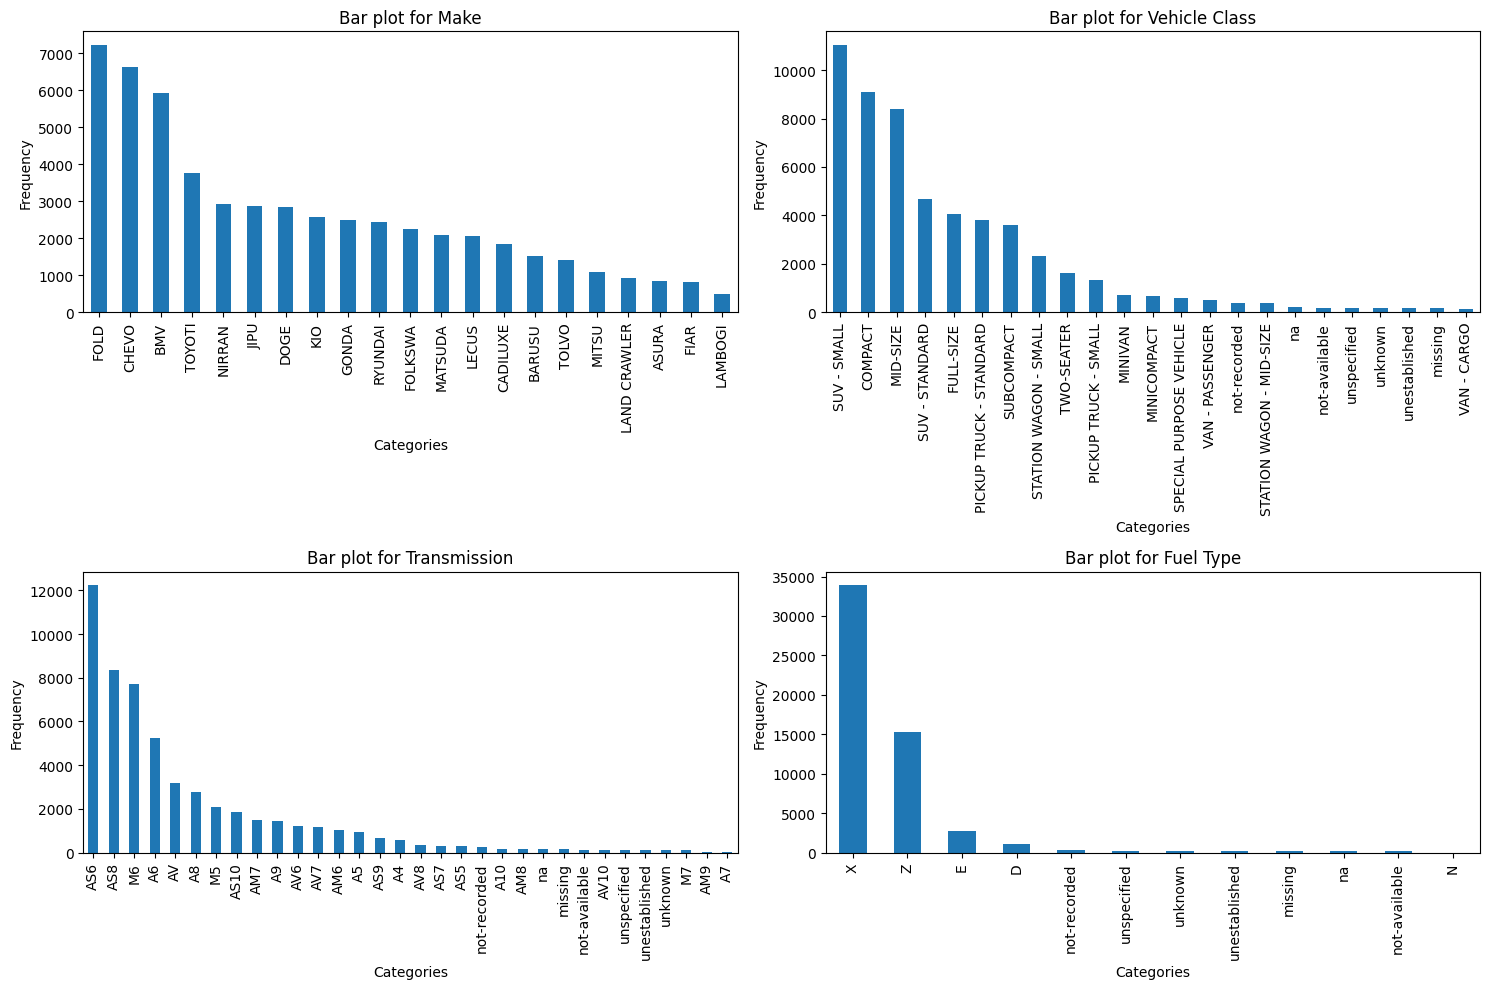

In [11]:
categorical = ["Make", "Vehicle Class", "Transmission", "Fuel Type"]

n = len(categorical)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))

for i, col in enumerate(categorical):
    r, c = i // ncols, i % ncols
    value_counts = df_train[col].value_counts()

    # Create a bar plot
    value_counts.plot(kind="bar", ax=axs[r, c])

    # Add title and labels
    axs[r, c].set_title(f"Bar plot for {col}")
    axs[r, c].set_xlabel("Categories")
    axs[r, c].set_ylabel("Frequency")

# Remove empty subplots
if n % ncols != 0:
    for j in range(n, nrows * ncols):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

inference: we got the list of weird nan values for the categorical column, so later we need to clean it

In [12]:
should_be_numerical = [
    "Fuel Consumption City",
    "Fuel Consumption Hwy",
    "Fuel Consumption Comb",
]

df_train_fuels = df_train[should_be_numerical].apply(pd.to_numeric, errors="coerce")
df_train_fuels.nunique()

Fuel Consumption City    0
Fuel Consumption Hwy     0
Fuel Consumption Comb    0
dtype: int64

inference: there were no int only values in fuel columns

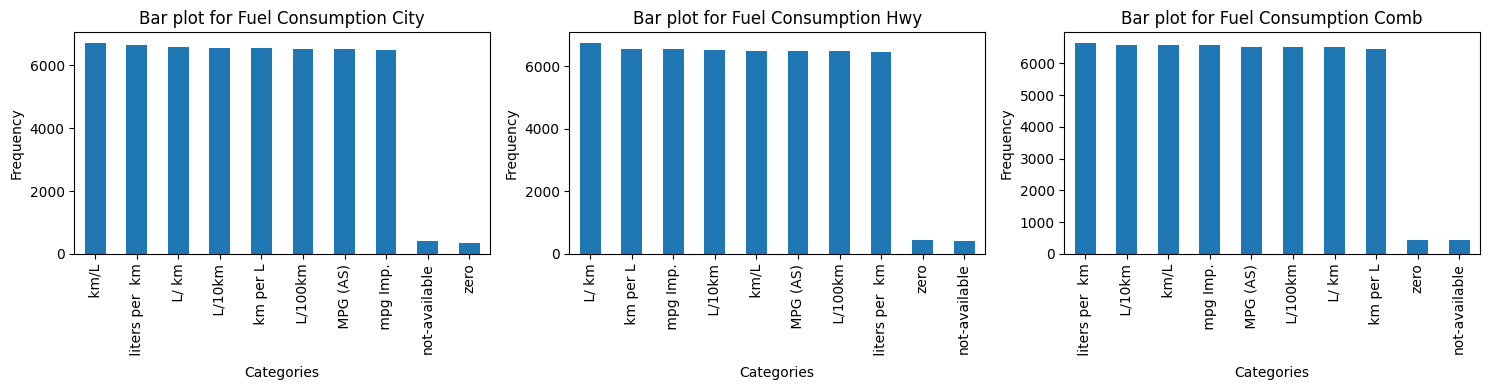

In [13]:
df_train_fuels = df_train[should_be_numerical].map(remove_numbers)

columns = df_train_fuels.columns.to_list()

n = len(columns)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))

for i, col in enumerate(columns):
    r, c = i // ncols, i % ncols
    value_counts = df_train_fuels[col].value_counts()

    # Create a bar plot
    if nrows == 1:
        ax = axs[c]
    else:
        ax = axs[r, c]
    value_counts.plot(kind="bar", ax=ax)

    # Add title and labels
    ax.set_title(f"Bar plot for {col}")
    ax.set_xlabel("Categories")
    ax.set_ylabel("Frequency")

# Remove empty subplots
if n % ncols != 0:
    for j in range(n, nrows * ncols):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

inference: above is the list of measurements of fuel columns, we can use it to convert all the measurement into 1 measurement (standardization). we will convert it into (L/100Km)

# Cleaning Data

In [14]:
need_to_clean_columns = [
    "Fuel Consumption City",
    "Fuel Consumption Hwy",
    "Fuel Consumption Comb",
]

float_columns = ["Engine Size(L)"]

int_columns = ["Cylinders"]

categorical_columns = ["Make", "Vehicle Class", "Transmission", "Fuel Type"]

### standardize fuel consumption columns

In [15]:
df_train[need_to_clean_columns] = df_train[need_to_clean_columns].apply(
    standardize_units, axis=1
)
df_test[need_to_clean_columns] = df_test[need_to_clean_columns].apply(
    standardize_units, axis=1
)

### converting all known weird values to nan (list were obtained from EDA)

In [16]:
values_to_replace = [
    "not-recorded",
    "missing",
    "na",
    "not-available",
    "unspecified",
    "unestablished",
    "unknown",
    "-1",
]

df_train = df_train.replace(values_to_replace, np.nan)
df_test = df_test.replace(values_to_replace, np.nan)

### changing dtypes

In [17]:
for col in float_columns:
    df_train[col] = df_train[col].astype(float)
    df_test[col] = df_test[col].astype(float)

for col in int_columns:
    df_train[col] = df_train[col].astype(float).astype("Int64")
    df_test[col] = df_test[col].astype(float).astype("Int64")

### eda after cleaning (convert weird nan values)

In [18]:
df_train.describe()

,Engine Size(L),Cylinders,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
count,49673.000000,50414.0,52612.000000,52374.000000,52385.000000
mean,2.978387,5.292379,12.554650,9.144982,11.023394
std,1.303561,1.600217,3.857020,2.344706,2.974402
min,1.000000,3.0,4.199836,4.000000,4.380000
25%,2.000000,4.0,9.900000,7.500000,8.876022
50%,2.500000,4.0,11.701781,8.599117,10.319917
75%,3.600000,6.0,15.105740,10.398523,13.002465
max,8.400000,12.0,30.500000,20.500000,25.316456


In [19]:
df_test.describe()

,Engine Size(L),Cylinders,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
count,21276.000000,21651.0,22504.000000,22478.000000,22508.000000
mean,2.976358,5.291118,12.520932,9.120457,10.990987
std,1.306311,1.594883,3.830391,2.344650,2.968518
min,1.000000,3.0,4.199836,4.000000,4.200000
25%,2.000000,4.0,9.900000,7.500000,8.849307
50%,2.500000,4.0,11.700000,8.598452,10.300000
75%,3.600000,6.0,15.100000,10.300000,12.996357
max,8.400000,12.0,30.500000,20.506938,25.700000


inference: both train and test data have a similar distribution which means that the test data is representative of the overall population

### see missing value

<Axes: >

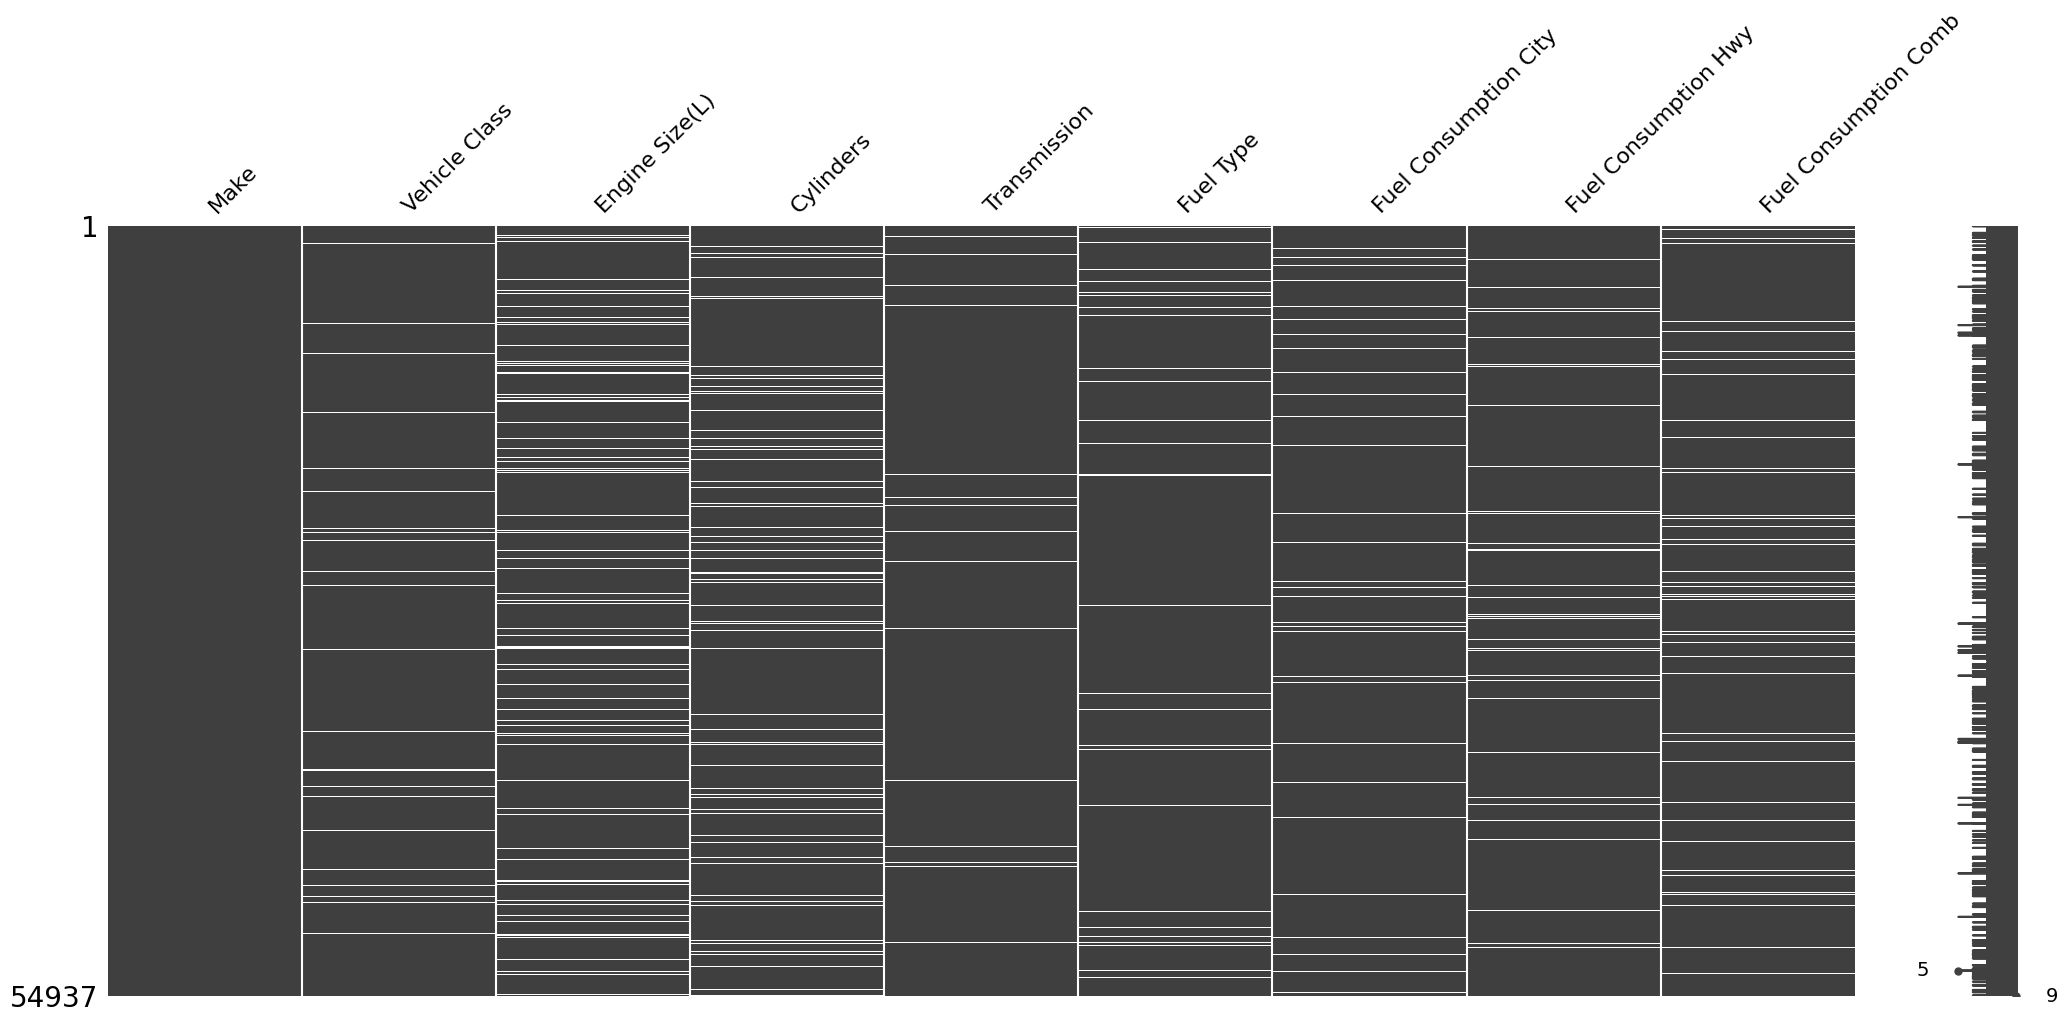

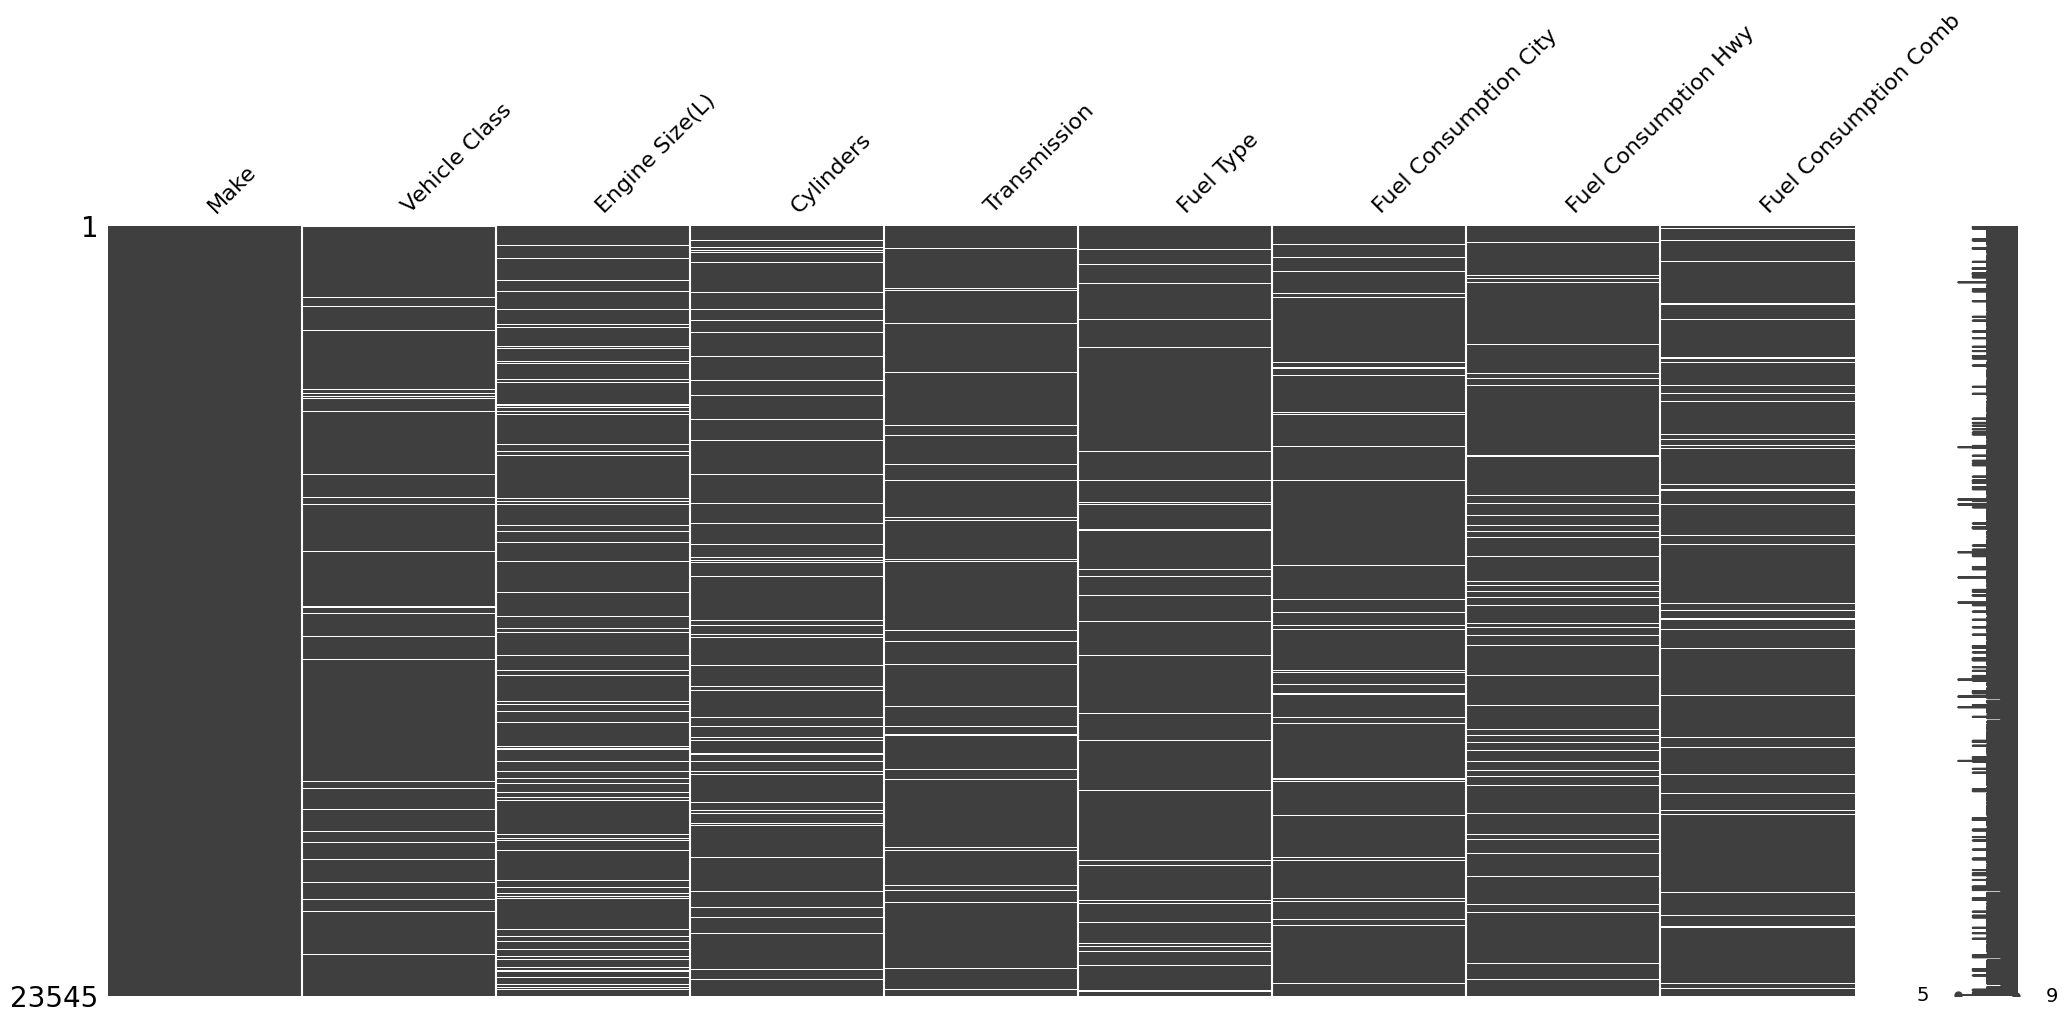

In [20]:
msno.matrix(df_train)
msno.matrix(df_test)

inference: high missing values can be seen on Engine Size and Cylinders feature. the distribution of missing value seems random, though some rows might have multiple missing values which means that it could be an error for the data.

### see correlation

c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


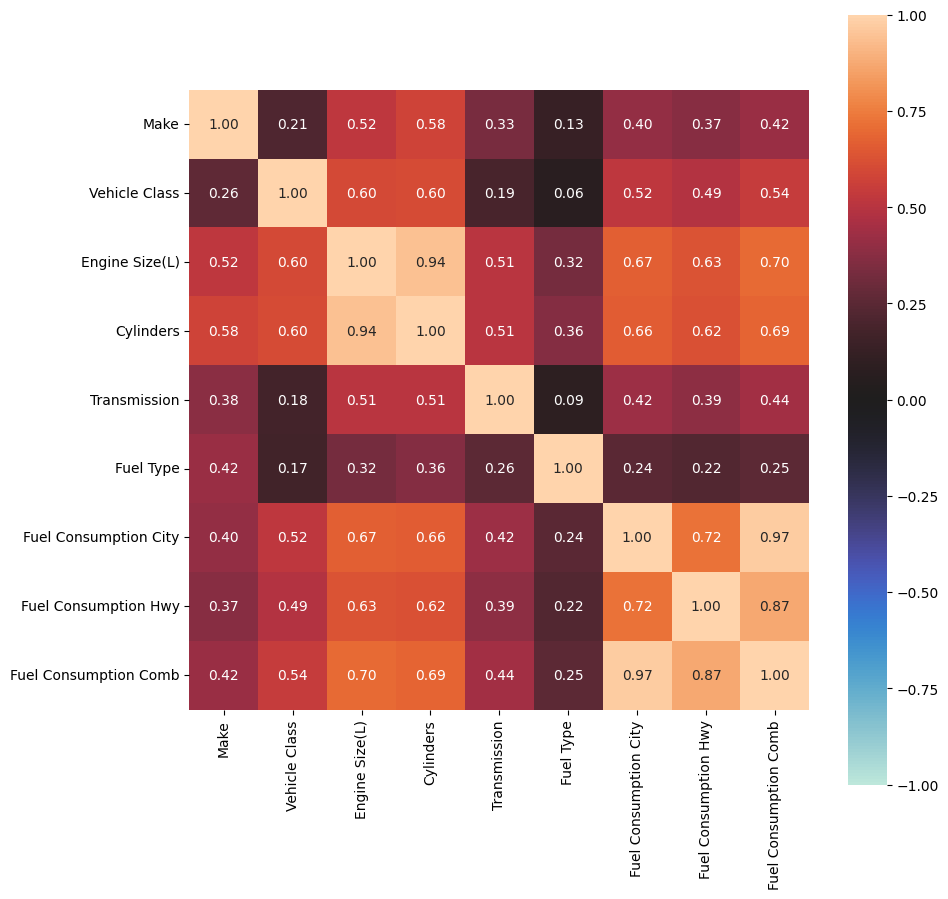

In [21]:
associations(
    df_train,
    nom_nom_assoc="theil",
    plot=True,
    nan_strategy="drop_samples",
    # clustering=True,
    figsize=(10, 10),
)
print()

c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


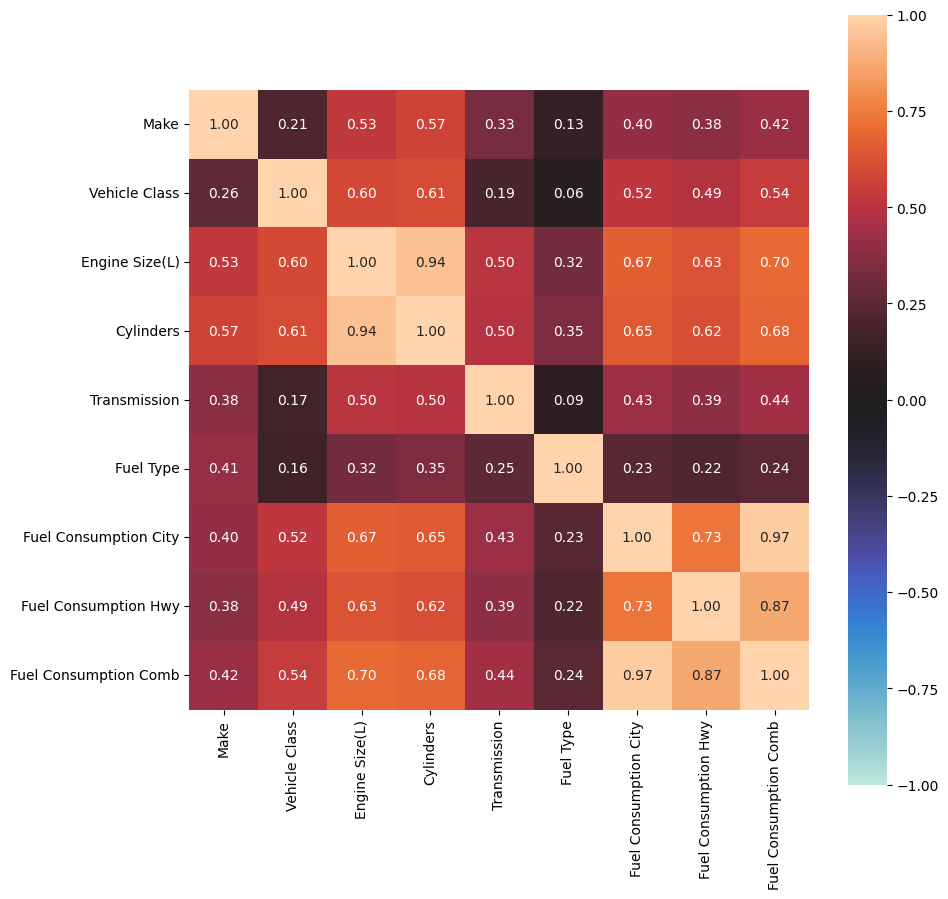

In [22]:
associations(
    df_test,
    nom_nom_assoc="theil",
    plot=True,
    nan_strategy="drop_samples",
    # clustering=True,
    figsize=(10, 10),
)
print()

inference: both shows equal correlation value, same as before, the test data is representative

c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


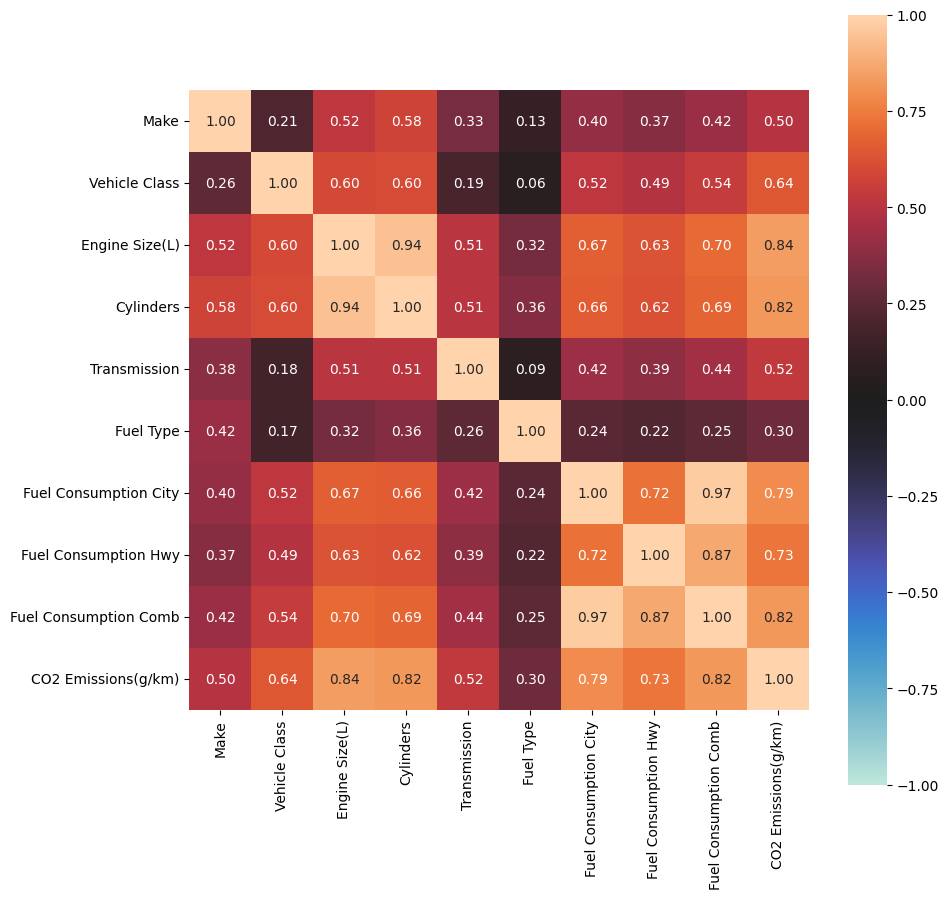

In [23]:
df_temp = pd.concat([df_train, df_train_target], axis=1)

associations(
    df_temp,
    nom_nom_assoc="theil",
    plot=True,
    nan_strategy="drop_samples",
    # clustering=True,
    figsize=(10, 10),
)
print()

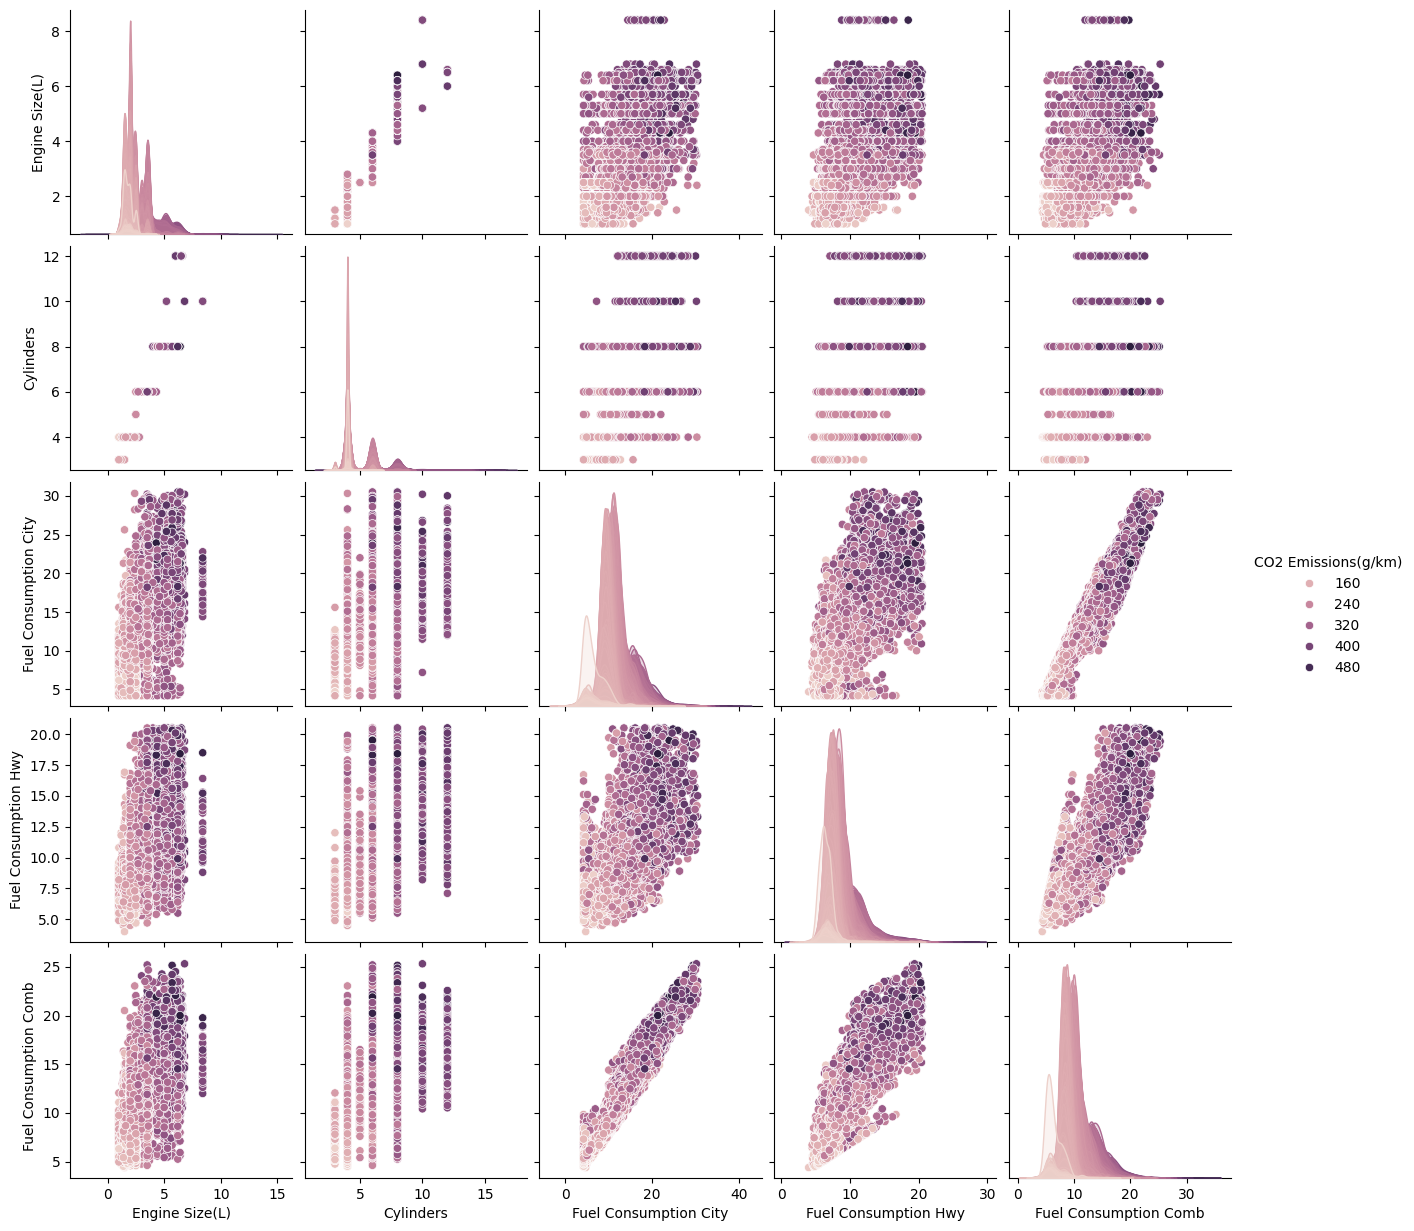

In [83]:
sns.pairplot(df_temp, hue="CO2 Emissions(g/km)")

inference: the overall distribution seems normal, though it has some outliers where it can be seen from the fuel consumption columns. high CO2 Emissions is showing in the lower value of Fuel Consumption, which is not normal because the fuel consumption features has a very high positive correlation with CO2 Emission (obtained from the correlation matrix) -> the higher the fuel consumption, the higher the CO2 Emission. Though, we can't straightly say that it is an outlier because there were other features that can affect the target variable (CO2 Emissions). But there is a potential for outliers.

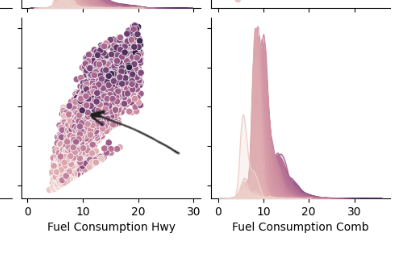

Cylinders, Engine Size, and Fuel Consumption features showing high correlation with the target. that means: vehicles with more cylinders tend to emit more CO2, on so on for the other mentioned features.

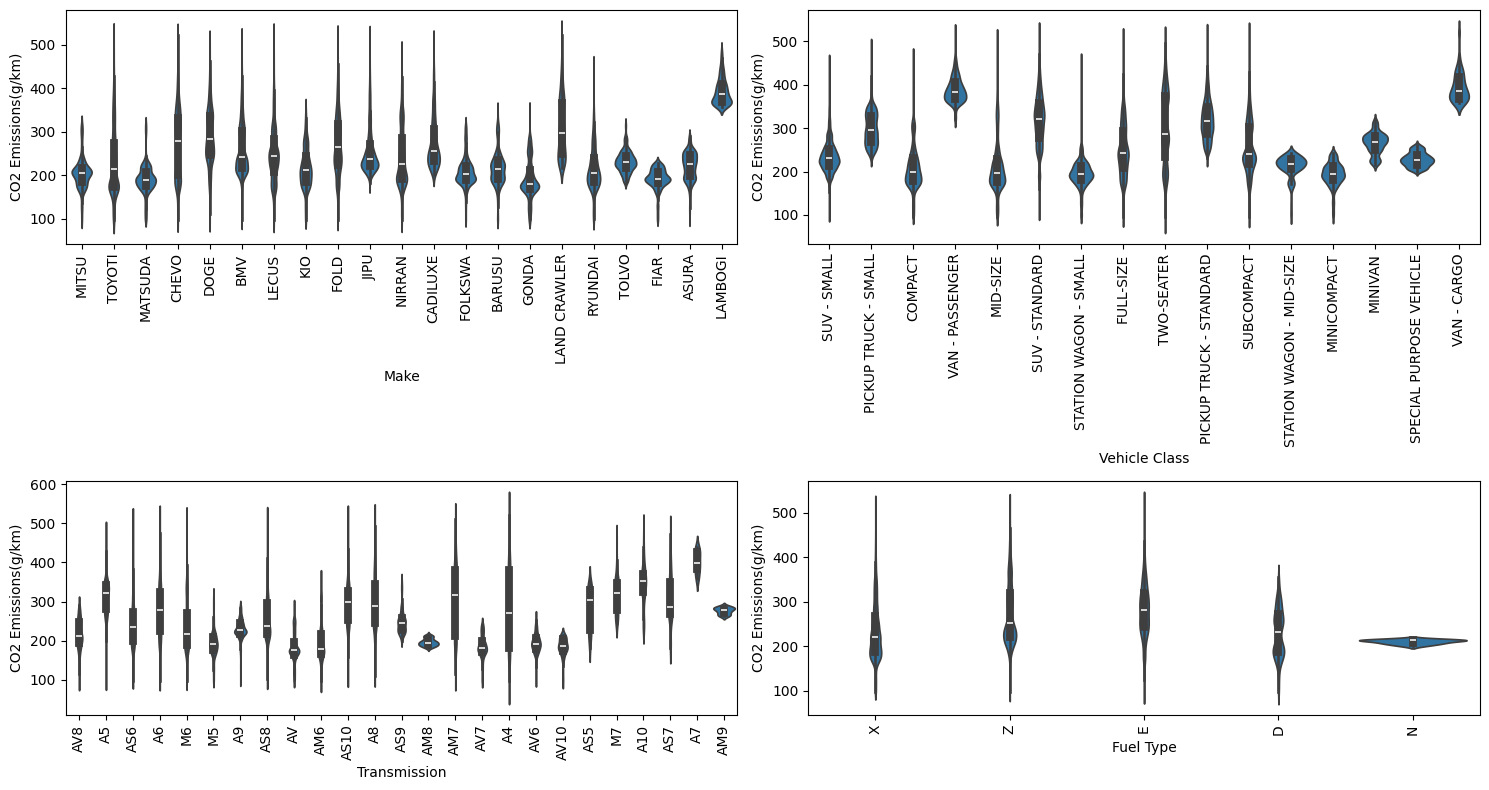

In [28]:
categorical_columns = df_train.select_dtypes(
    exclude=["int64", "float64"]
).columns.tolist()
target_feature = "CO2 Emissions(g/km)"

n = len(categorical_columns)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))

for i, col in enumerate(categorical_columns):
    r, c = i // ncols, i % ncols
    sns.violinplot(x=col, y=target_feature, data=df_temp, ax=axs[r, c])
    plt.setp(axs[r, c].xaxis.get_majorticklabels(), rotation=90) 

# Remove empty subplots
if n % ncols != 0:
    for j in range(n, nrows * ncols):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

inference: some values of the features affect the value of the target feature. for example AV8 tend to have low emission around 100 - 300. The information above can also be concluded from the correlation matrix before. the medium correlated features can be seen where it has > 0.50 on the correlation matrix.

### apply feature engineering

In [15]:
df_train

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,MITSU,SUV - SMALL,1.5,4,AV8,X,11.904762,7.200000,9.800000
1,TOYOTI,PICKUP TRUCK - SMALL,NaN,6,A5,X,13.793103,9.700000,11.960000
2,MATSUDA,COMPACT,2.0,4,AS6,X,10.204082,7.299251,8.894238
3,CHEVO,VAN - PASSENGER,NaN,8,A6,X,17.300000,11.700000,14.780000
4,TOYOTI,COMPACT,1.8,4,M6,X,8.100000,7.899357,8.010000
...,...,...,...,...,...,...,...,...,...
54932,CHEVO,SUBCOMPACT,6.2,8,AS10,Z,11.900000,8.802817,10.505341
54933,CHEVO,SUBCOMPACT,3.6,6,M6,X,21.000000,10.600000,16.323011
54934,FOLD,TWO-SEATER,3.5,6,AM7,Z,18.200000,12.500000,15.630000
54935,CHEVO,PICKUP TRUCK - STANDARD,6.2,8,A8,Z,18.300000,9.900000,14.520000


create new features from existing feature.
- Vehicle Class -> can be separated from its size: SMALL, COMPACT, STANDARD, ...
- Vehicle Class -> can also be grouped based on the vehicle: SUV, VAN, ...
- Transmission -> Map to automatic/manual, extract the gear

In [16]:
df_train = process_transmission(df_train)
df_test = process_transmission(df_test)

df_train = group_vehicle_classes(df_train)
df_test = group_vehicle_classes(df_test)

df_train = group_vehicle_types(df_train)
df_test = group_vehicle_types(df_test)

In [17]:
df_train

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Transmission_Type,Gears,Vehicle Class General,Vehicle Type
0,MITSU,SUV - SMALL,1.5,4,AV8,X,11.904762,7.200000,9.800000,Automatic,8,SUV,SMALL
1,TOYOTI,PICKUP TRUCK - SMALL,NaN,6,A5,X,13.793103,9.700000,11.960000,Automatic,5,PICKUP TRUCK,SMALL
2,MATSUDA,COMPACT,2.0,4,AS6,X,10.204082,7.299251,8.894238,Automatic,6,COMPACT,COMPACT
3,CHEVO,VAN - PASSENGER,NaN,8,A6,X,17.300000,11.700000,14.780000,Automatic,6,VAN,PASSENGER
4,TOYOTI,COMPACT,1.8,4,M6,X,8.100000,7.899357,8.010000,Manual,6,COMPACT,COMPACT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,CHEVO,SUBCOMPACT,6.2,8,AS10,Z,11.900000,8.802817,10.505341,Automatic,10,SUBCOMPACT,SUBCOMPACT
54933,CHEVO,SUBCOMPACT,3.6,6,M6,X,21.000000,10.600000,16.323011,Manual,6,SUBCOMPACT,SUBCOMPACT
54934,FOLD,TWO-SEATER,3.5,6,AM7,Z,18.200000,12.500000,15.630000,Automatic,7,TWO-SEATER,TWO-SEATER
54935,CHEVO,PICKUP TRUCK - STANDARD,6.2,8,A8,Z,18.300000,9.900000,14.520000,Automatic,8,PICKUP TRUCK,STANDARD


c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


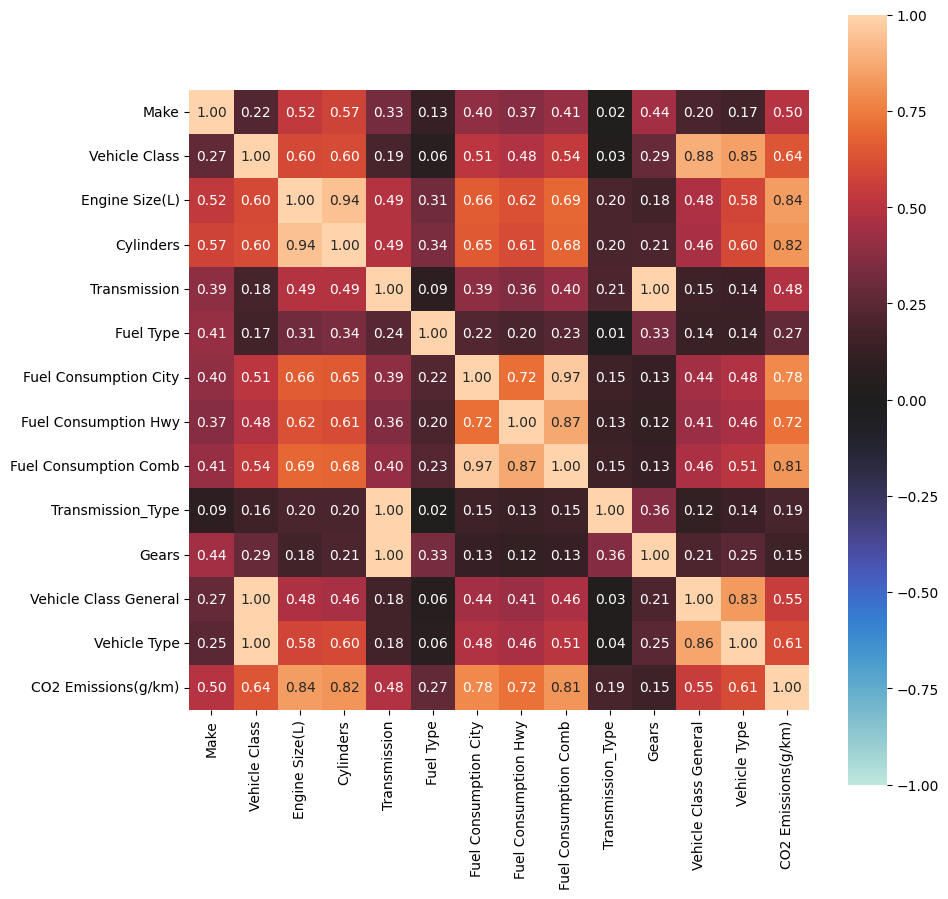

In [18]:
df_temp = pd.concat([df_train, df_train_target], axis=1)

associations(
    df_temp,
    nom_nom_assoc="theil",
    plot=True,
    nan_strategy="drop_samples",
    # clustering=True,
    figsize=(10, 10),
)
print()

inference: some of the engineered features seems have a medium correlation with the target values (Vehicle Type, Vehicle Class General). this hopes that the model performance can increase because of this preprocessing steps.

# Handling Outliers

<Axes: >

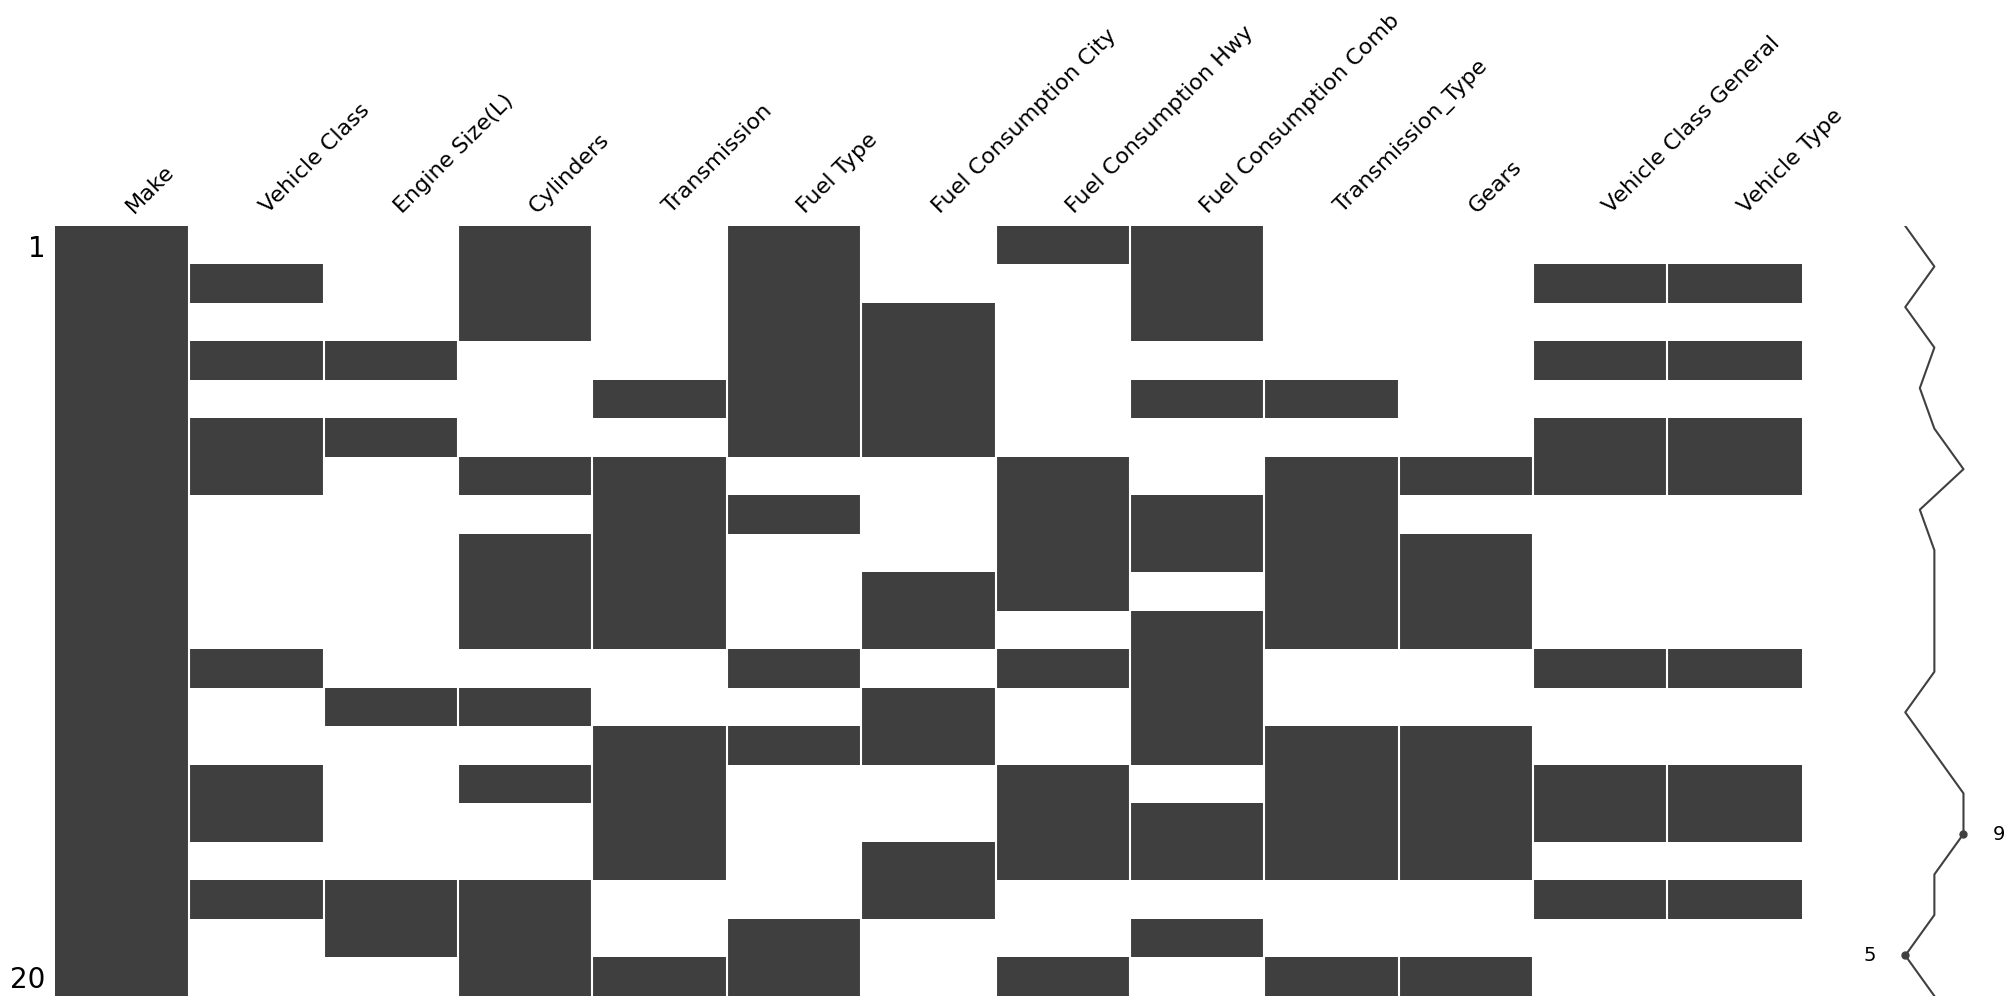

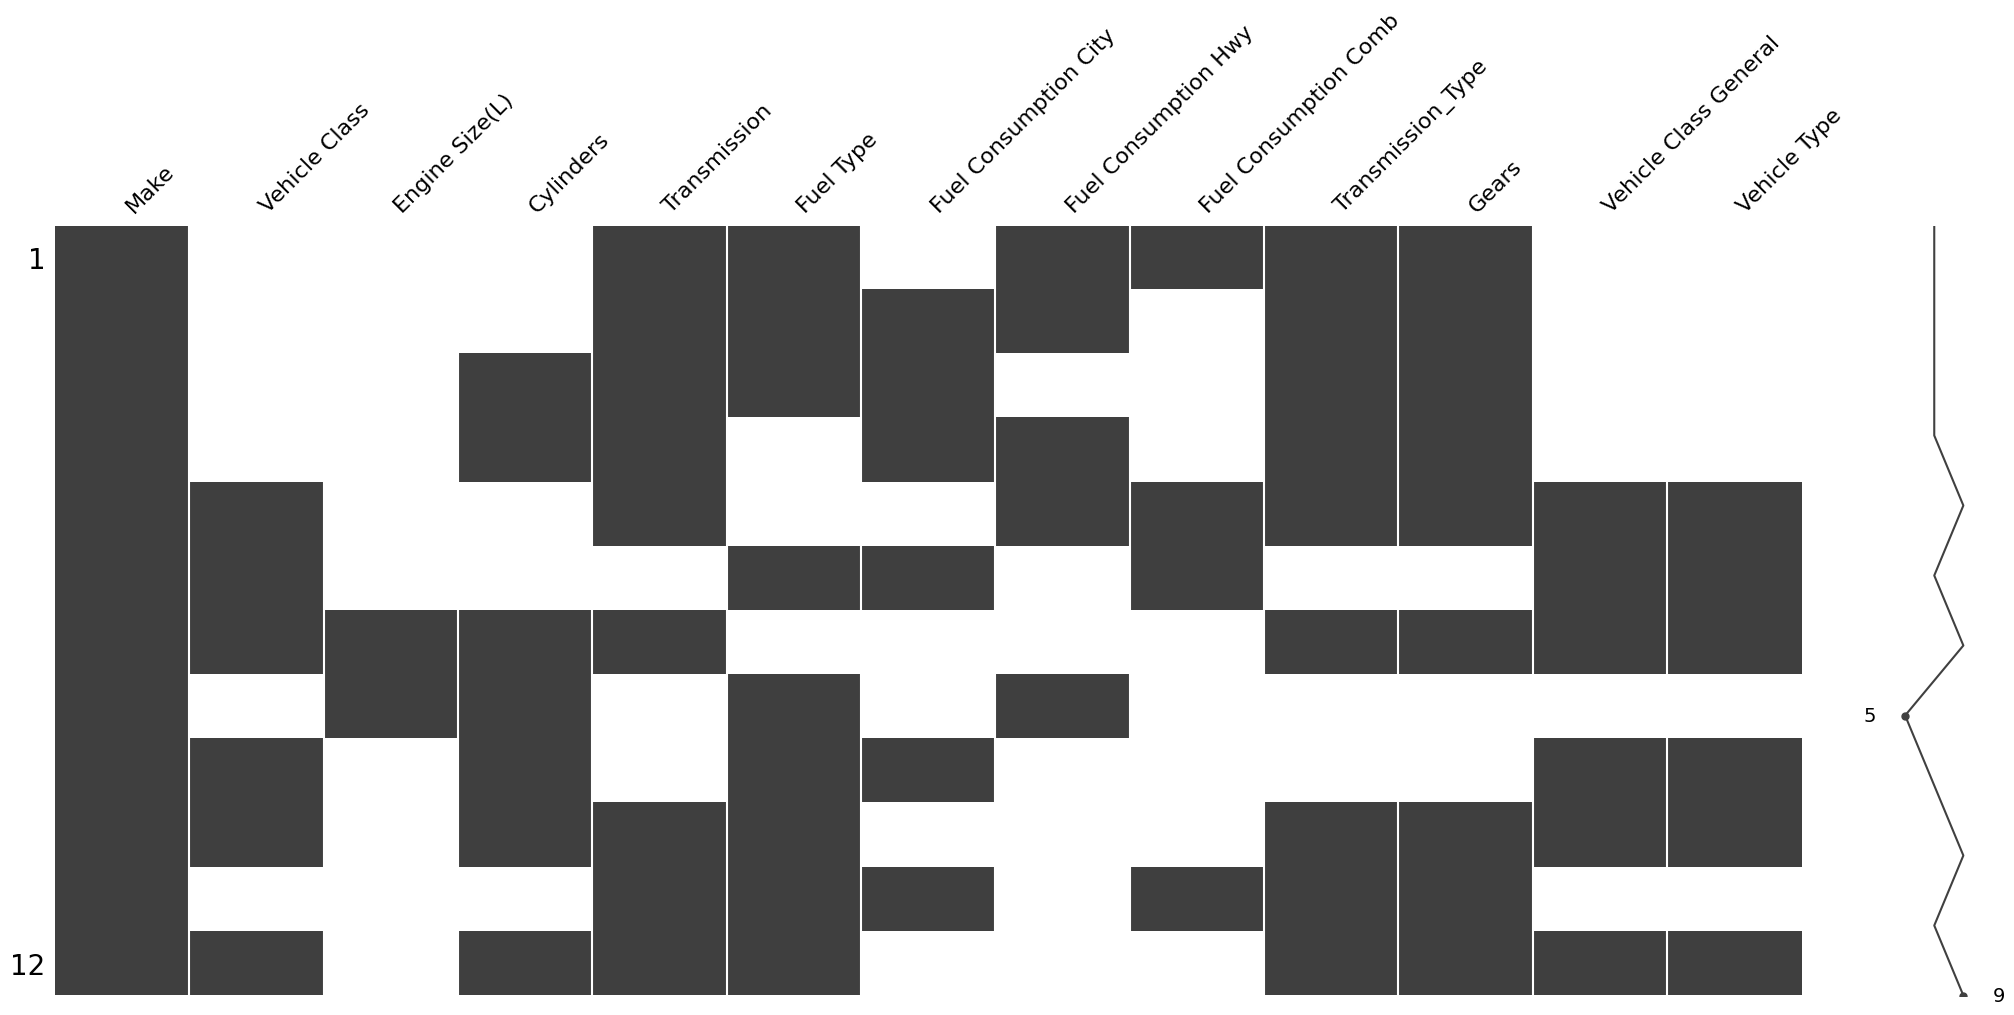

In [19]:
valid_columns = [
    "Make",
    "Vehicle Class",
    "Engine Size(L)",
    "Cylinders",
    "Transmission",
    "Fuel Type",
    "Fuel Consumption City",
    "Fuel Consumption Hwy",
    "Fuel Consumption Comb",
]

multiple_missing_train = find_rows_with_missing_values(df_train, valid_columns, 4)
multiple_missing_test = find_rows_with_missing_values(df_test, valid_columns, 4)

msno.matrix(multiple_missing_train)
msno.matrix(multiple_missing_test)

inference: above is the further investigation of the multiple missing values (4 missing values to be exact) on a row, 20 data exsisted on the training set and 12 on the test set. it seems pretty small and doesn't cause any problem, so we can just impute the missing value later, no need to drop it.

In [20]:
float_columns_df = df_train.select_dtypes(include=["float64"])

bounds = calculate_iqr(df_train, float_columns_df, 1.5)
print('Detected outliers on Train Data: ')
df_train = detect_outliers(df_train, bounds)
print('\nDetected outliers on Test Data: ')
df_test = detect_outliers(df_test, bounds)

Detected outliers on Train Data: 
Column: Engine Size(L), Number of Outliers: 2005
Column: Fuel Consumption City, Number of Outliers: 479
Column: Fuel Consumption Hwy, Number of Outliers: 1578
Column: Fuel Consumption Comb, Number of Outliers: 570

Detected outliers on Test Data: 
Column: Engine Size(L), Number of Outliers: 887
Column: Fuel Consumption City, Number of Outliers: 195
Column: Fuel Consumption Hwy, Number of Outliers: 683
Column: Fuel Consumption Comb, Number of Outliers: 243


In [21]:
print("Total outliers on Train Data: ")
print(df_train["is_outlier"].value_counts())

print("Total outliers on Test Data: ")
print(df_test["is_outlier"].value_counts())

Total outliers on Train Data: 
is_outlier
0    51360
1     3577
Name: count, dtype: int64
Total outliers on Test Data: 
is_outlier
0    21991
1     1554
Name: count, dtype: int64


inference: there is a pattern where the outliers of the train data tends to be doubled (2.2 ~ 2.3 times) the test data. Due to that information, we chose not to drop the outliers but decided to add new feature called "is_outlier", hoping that it could help increase the performance of the model.

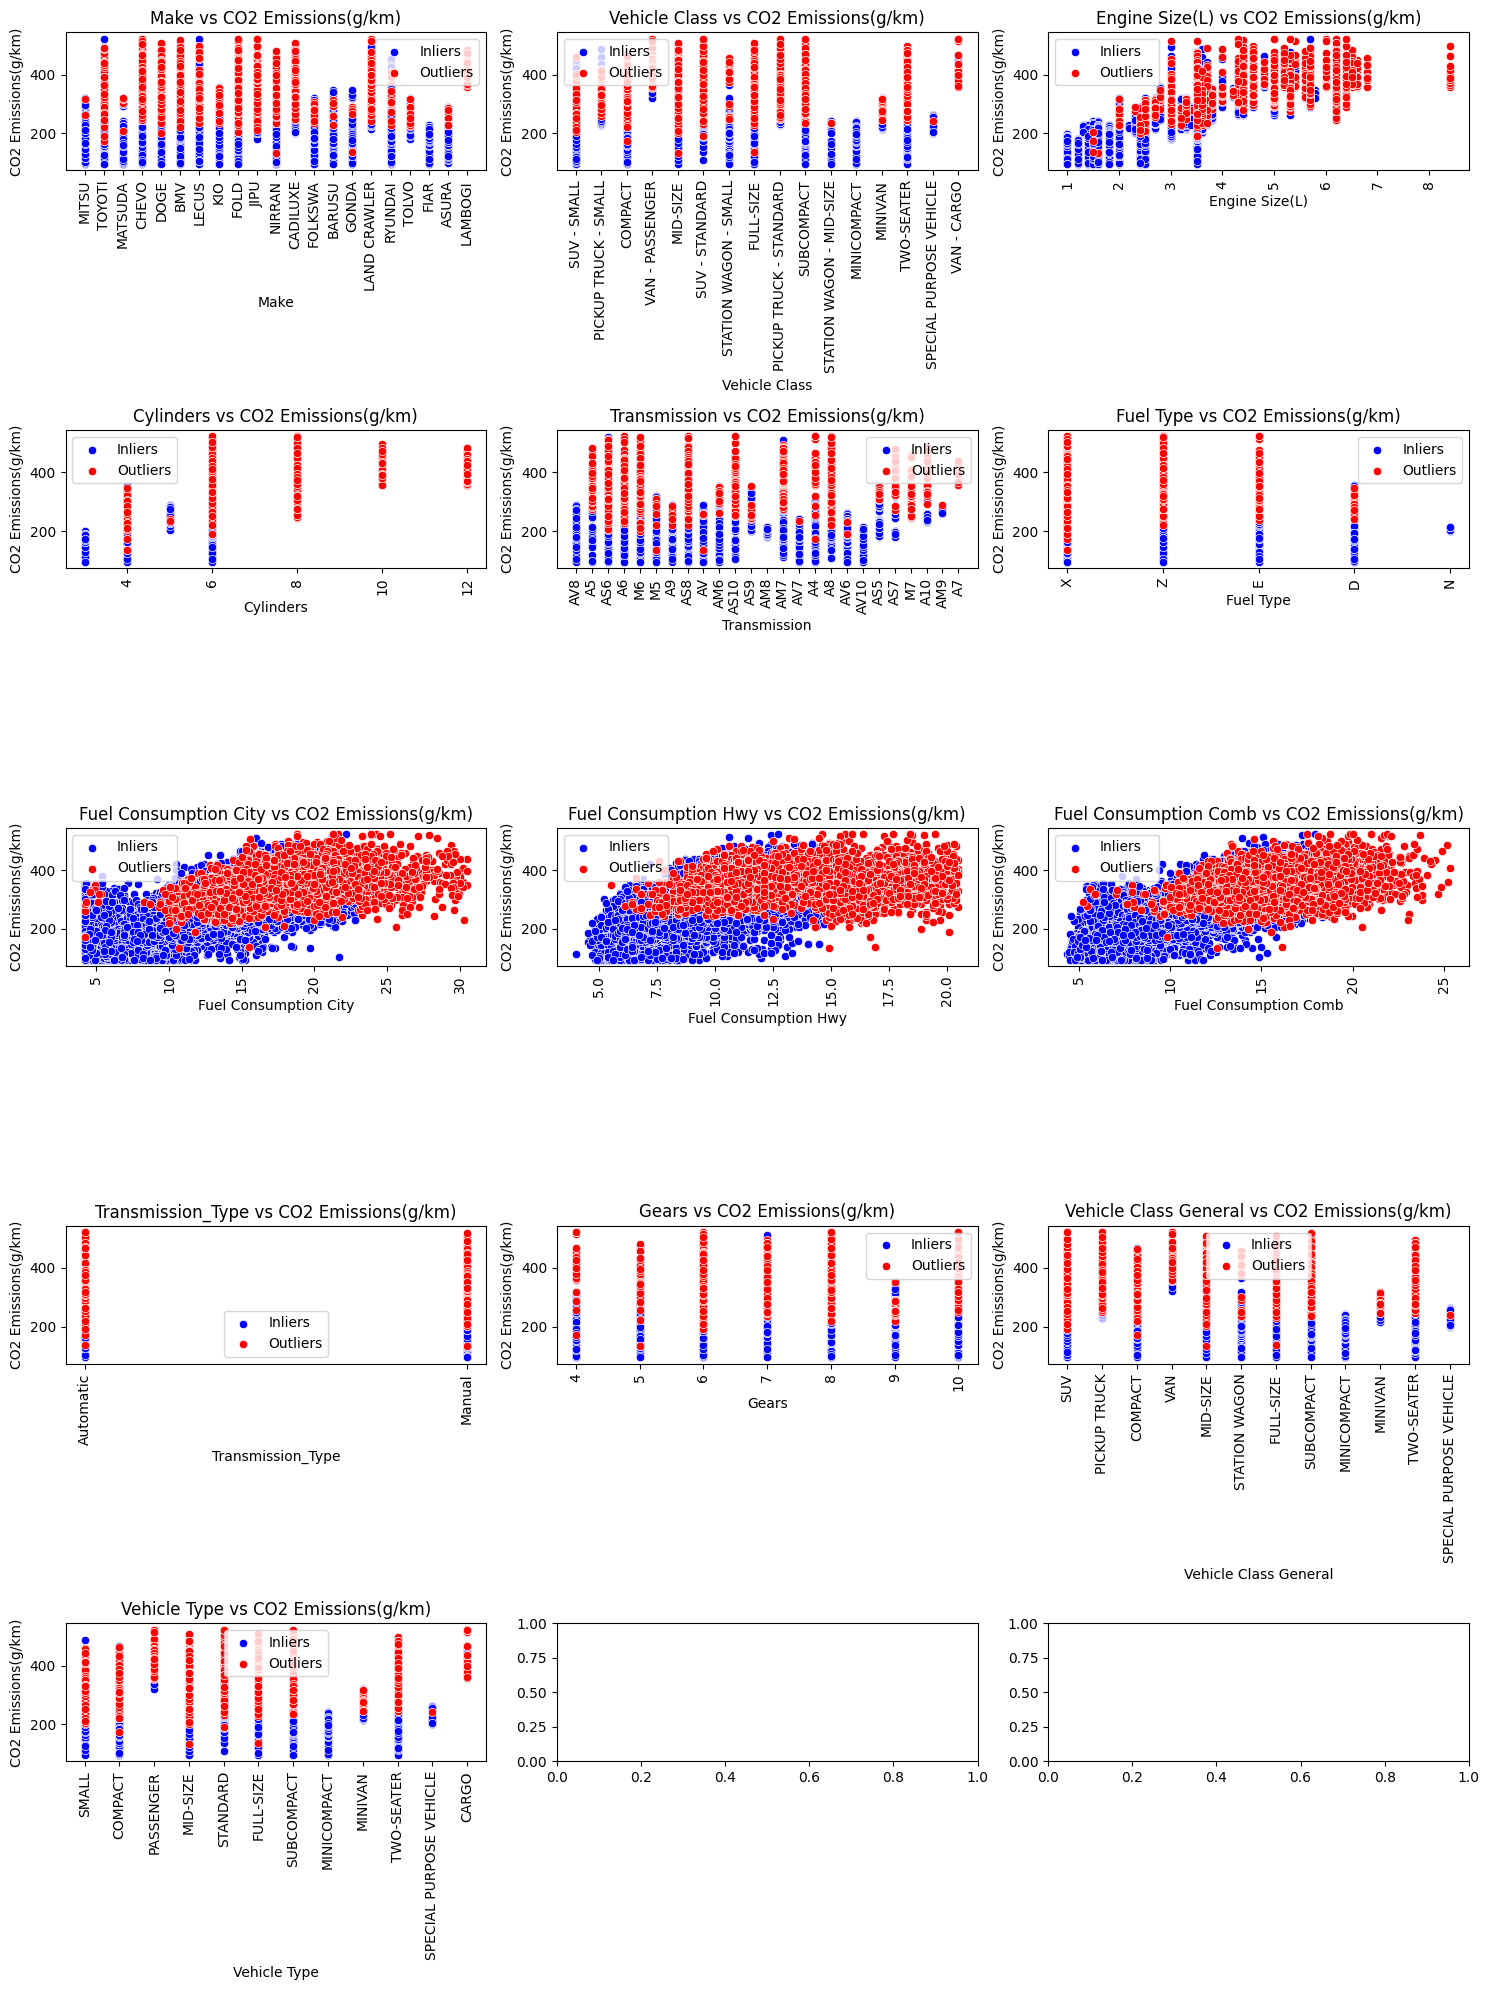

In [22]:
df_temp = pd.concat([df_train, df_train_target], axis=1)

outliers = df_temp[df_temp["is_outlier"] == 1]
inliers = df_temp[df_temp["is_outlier"] == 0]

features = df_temp.columns.drop(["is_outlier", "CO2 Emissions(g/km)"])

fig, axes = plt.subplots(5, 3, figsize=(15, 20))


for i, feature in enumerate(features):
    row = i // 3
    col = i % 3

    sns.scatterplot(
        x=inliers[feature],
        y=inliers["CO2 Emissions(g/km)"],
        color="b",
        label="Inliers",
        ax=axes[row, col],
    )

    sns.scatterplot(
        x=outliers[feature],
        y=outliers["CO2 Emissions(g/km)"],
        color="r",
        label="Outliers",
        ax=axes[row, col],
    )

    axes[row, col].set_title(f"{feature} vs CO2 Emissions(g/km)")
    axes[row, col].set_xlabel(feature)
    axes[row, col].tick_params(axis="x", rotation=90)
    axes[row, col].set_ylabel("CO2 Emissions(g/km)")
    axes[row, col].legend()

plt.tight_layout()

plt.show()

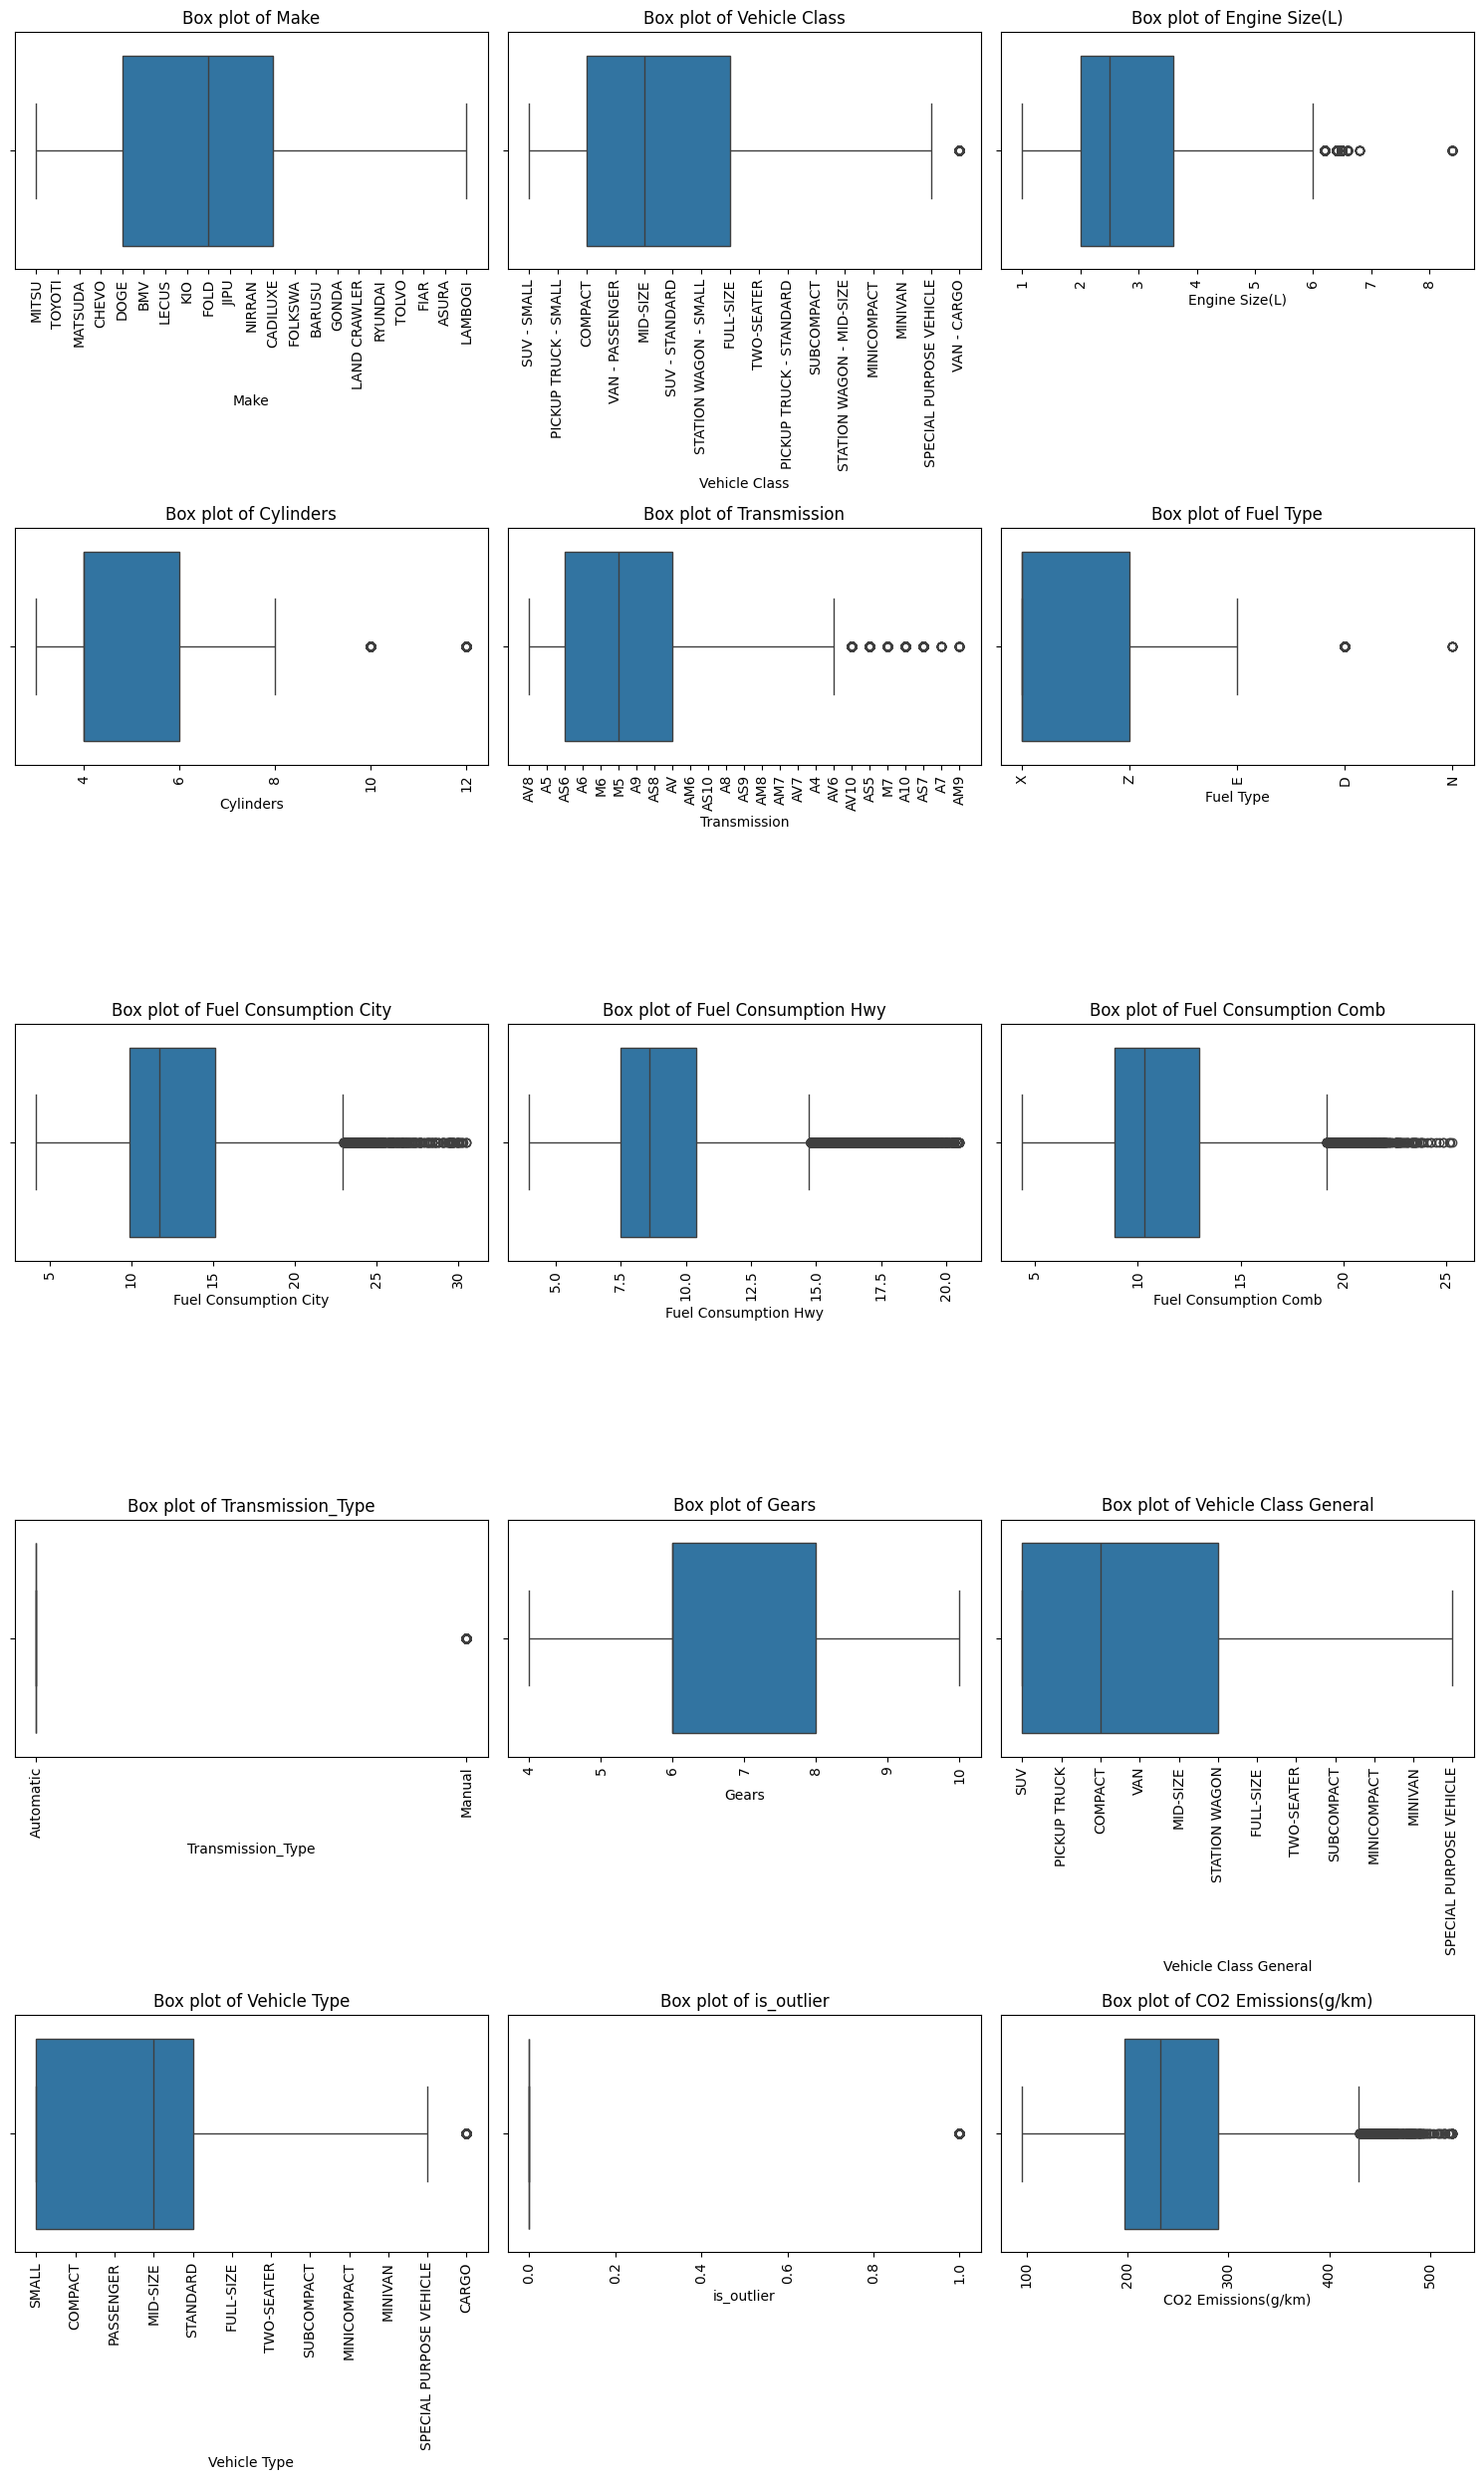

In [23]:
num_plots = len(df_temp.columns)
num_cols = 3
num_rows = (
    num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1
)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i, column in enumerate(df_temp.columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=df_temp[column], ax=axs[row, col])
    axs[row, col].set_title(f"Box plot of {column}")
    axs[row, col].tick_params(axis="x", rotation=90) 

plt.tight_layout()
plt.show()

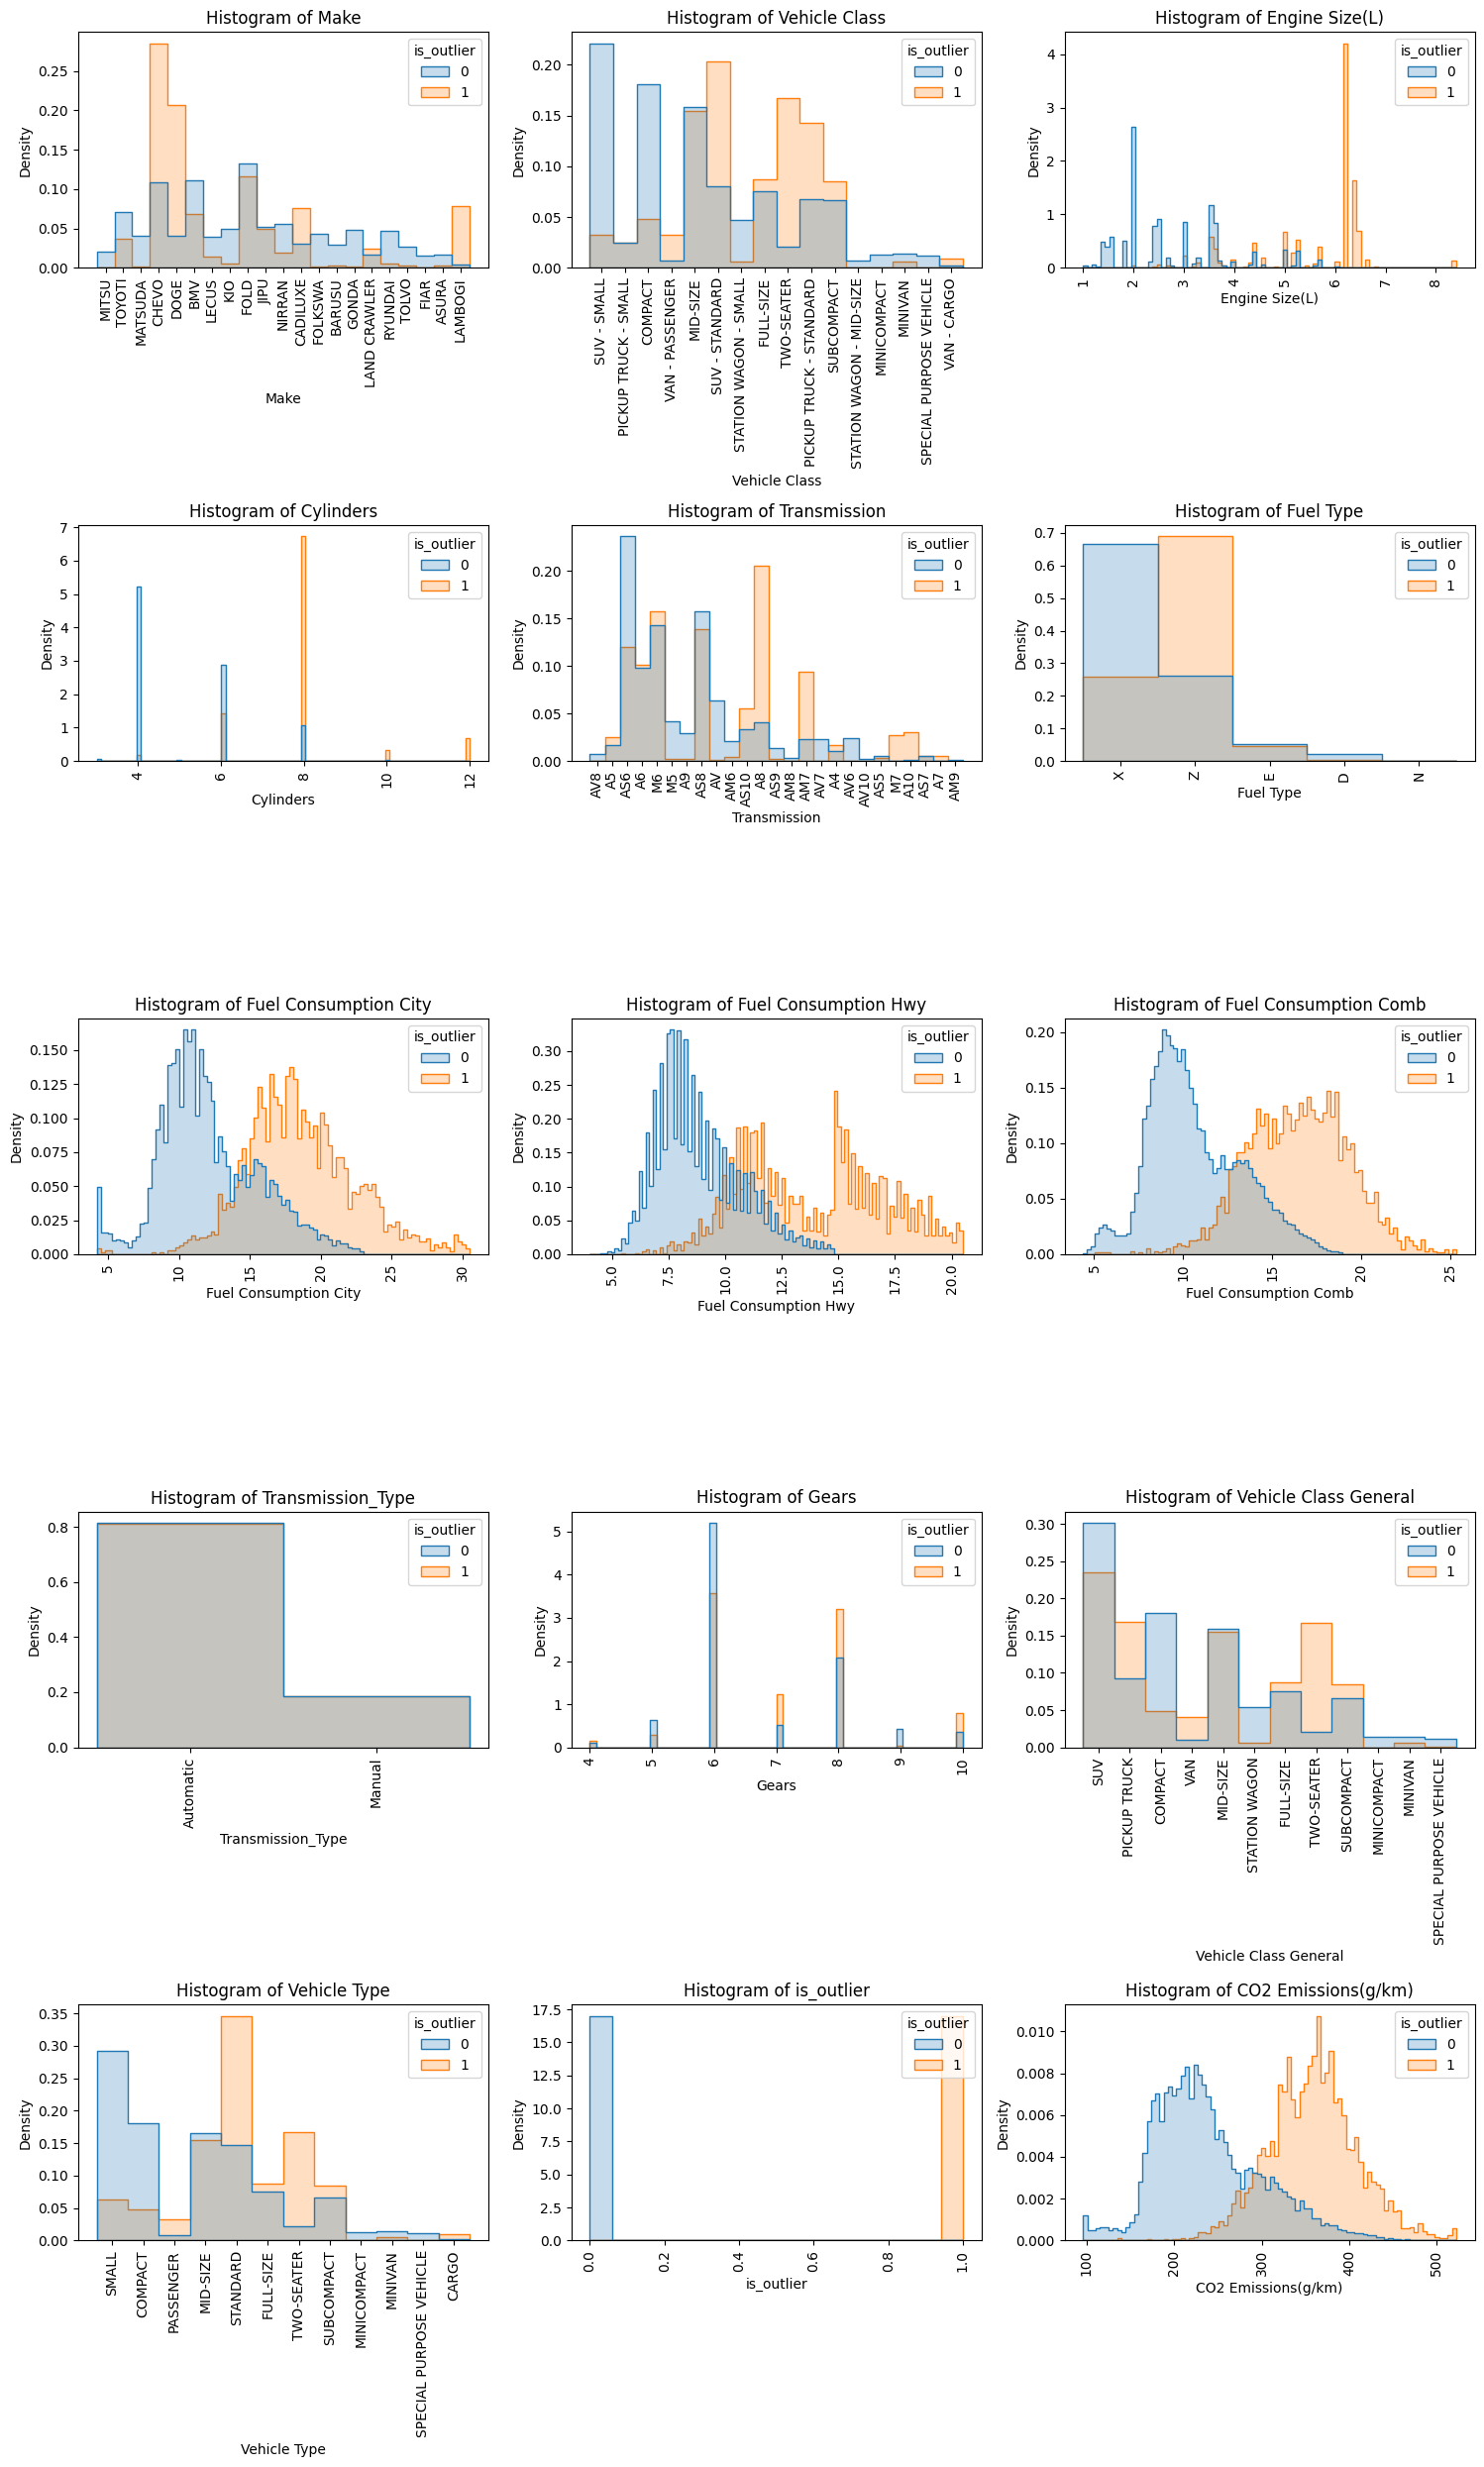

In [24]:
num_plots = len(df_temp.columns)
num_cols = 3
num_rows = (
    num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1
)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i, column in enumerate(df_temp.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(
        data=df_temp,
        x=column,
        hue="is_outlier",
        element="step",
        stat="density",
        common_norm=False,
        ax=axs[row, col],
    )
    axs[row, col].set_title(f"Histogram of {column}")
    axs[row, col].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

inference: outliers density shows pretty representative compared to the non outliers data.

# Imputation with mice forest

In [25]:
# we must change the type of the categorical columns to category so mice forest can identify and impute categorical columns

for col in df_train.columns:
    if df_train[col].dtype == "object":
        df_train[col] = df_train[col].astype("category")

for col in df_test.columns:
    if df_test[col].dtype == "object":
        df_test[col] = df_test[col].astype("category")

In [26]:
# choosing a set of features for each imputation, selected by seeing the correlation matrix of each individual feature

fuel_consumption_features = [
    "Fuel Consumption City",
    "Fuel Consumption Hwy",
    "Fuel Consumption Comb",
    # "CO2 Emissions(g/km)",
]

engine_cylinders_features = [
    "Engine Size(L)",
    "Cylinders",
    # "Vehicle Class",
    # "Vehicle Type",
    "Make",
    "Fuel Consumption City",
    "Fuel Consumption Hwy",
    "Fuel Consumption Comb",
    # "CO2 Emissions(g/km)",
]

categorical_features = [
    "Vehicle Class",
    "Transmission",
    "Fuel Type",
    "Make",
    "Engine Size(L)",
    "Cylinders",
    # "CO2 Emissions(g/km)",
]

In [27]:
df_train = pd.concat([df_train, df_train_target], axis=1)
df_train = impute_data(df_train, fuel_consumption_features + ["CO2 Emissions(g/km)"])
df_train_target = df_train.pop("CO2 Emissions(g/km)")
kds = train_imputation_kernel(df_train, fuel_consumption_features)
df_test = impute_data(df_test, fuel_consumption_features, kds)

In [28]:
df_train = pd.concat([df_train, df_train_target], axis=1)
df_train = impute_data(df_train, engine_cylinders_features + ["CO2 Emissions(g/km)"])
df_train_target = df_train.pop("CO2 Emissions(g/km)")
kds = train_imputation_kernel(df_train, engine_cylinders_features)
df_test = impute_data(df_test, engine_cylinders_features, kds)

In [29]:
df_train = pd.concat([df_train, df_train_target], axis=1)
df_train = impute_data(df_train, categorical_features + ["CO2 Emissions(g/km)"])
df_train_target = df_train.pop("CO2 Emissions(g/km)")
kds = train_imputation_kernel(df_train, categorical_features)
df_test = impute_data(df_test, categorical_features, kds)

c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\miceforest\ImputationKernel.py:370: UserWarning: [Transmission,Fuel Type] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(
c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\miceforest\ImputationKernel.py:370: UserWarning: [Transmission,Fuel Type] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [31]:
# switch back the categorical columns to object type for feature engineering

for col in df_train.columns:
    if df_train[col].dtype == "category":
        df_train[col] = df_train[col].astype("object")

for col in df_test.columns:
    if df_test[col].dtype == "category":
        df_test[col] = df_test[col].astype("object")

df_train = process_transmission(df_train)
df_test = process_transmission(df_test)

df_train = group_vehicle_classes(df_train)
df_test = group_vehicle_classes(df_test)

df_train = group_vehicle_types(df_train)
df_test = group_vehicle_types(df_test)

# filling nan on gears column with -1 (not every Transmission has gears)
df_train = df_train.fillna(-1)
df_test = df_test.fillna(-1)

# Modeling

## Note:

This section only provide the hypertuned params and model, we tested various model (NN, SVR, XGBoost, RF, LGBM, XGBRF, Stacking, Bagging), data preprocessing (dropping outliers, feature engineering, scaling and encoding techniques), and chose the best pipeline then hypertune the selected model using BayesianOptimization.

## Training and Evaluation

In [32]:
random_state = 42

lgbm_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "bagging_fraction": 0.8690077395539522,
    "feature_fraction": 0.7100616390120457,
    "lambda_l1": 17.140478403668403,
    "lambda_l2": 43.36675440761465,
    "learning_rate": 0.06900334013323922,
    "max_depth": int(5.299581326745951),
    "min_data_in_leaf": int(210.02583586502402),
    "min_gain_to_split": 1.5177861953751233,
    "num_leaves": int(2150.5332871592927),
}

xgb_params = {
    "colsample_bytree": 0.3,
    "eta": 0.03508222219931691,
    "gamma": 0.7686173125574116,
    "max_delta_step": 0.0,
    "max_depth": int(8.350757895869842),
    "min_child_weight": 0.3,
    "reg_alpha": 0.19008440126889958,
    "reg_lambda": 0.7610085486525633,
    "scale_pos_weight": 13.442385709119758,
    "subsample": 1.0,
}

model_lgbm = lgb.LGBMRegressor(
    n_estimators=1000, random_state=random_state, **lgbm_params
)
model_xgb = XGBRegressor(n_estimators=1000, random_state=random_state, **xgb_params)
model_rf = RandomForestRegressor(random_state=random_state)
model_ensemble = StackingRegressor(
    estimators=[
        ("xgb", model_xgb),
        ("lgbm", model_lgbm),
        ("rf", model_rf),
    ],
)

In [33]:
onehot_columns = [
    "Make",
    "Fuel Type",
    "Transmission_Type",
    "Vehicle Class General",
    "Gears",
    "is_outlier",
]
binary_columns = ["Vehicle Class", "Transmission"]
ordinal_columns = ["Vehicle Type"]

numerical_columns = df_train.select_dtypes(include="float64").columns.tolist()

In [36]:
models = [
    model_xgb,
    model_ensemble,
]

datasets = [
    df_train,
]

datasets_columns = [
    {
        "onehot": onehot_columns,
        "binary": binary_columns,
        "ordinal": ordinal_columns,
        "numerical": numerical_columns,
    },
]

y = df_train_target

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

preprocessing_steps = [
    {"name": "standard_scale_dataframe", "func": standard_scale_dataframe},
]

for i, model in enumerate(models):
    model_name = type(model).__name__ + f"{i+1}"
    print(model_name)
    results[model_name] = {}

    for i, (dataset, dataset_columns) in enumerate(zip(datasets, datasets_columns)):
        results[model_name][f"dataset_{i+1}"] = {
            "rmse": [],
            "training_time": [],
        }

        onehot_columns = dataset_columns["onehot"]
        binary_columns = dataset_columns["binary"]
        ordinal_columns = dataset_columns["ordinal"]
        numerical_columns = dataset_columns["numerical"]

        for train_index, test_index in kf.split(dataset):
            X_train, X_test = dataset.iloc[train_index], dataset.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            X_train, X_test = encode_categorical_features(
                X_train,
                X_test,
                onehot_columns,
                binary_columns,
                ordinal_columns,
            )

            for step in preprocessing_steps:
                preprocessing_func = step["func"]

                X_train, X_test = preprocessing_func(X_train, X_test, numerical_columns)

                start_time = time.time()

                model.fit(X_train, y_train)

                end_time = time.time()

                training_time = end_time - start_time

                predictions = model.predict(X_test)

                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)

                if step["name"] not in results[model_name][f"dataset_{i+1}"]:
                    results[model_name][f"dataset_{i+1}"][step["name"]] = {
                        "rmse": [],
                        "training_time": [],
                    }

                results[model_name][f"dataset_{i+1}"][step["name"]]["rmse"].append(rmse)
                results[model_name][f"dataset_{i+1}"][step["name"]][
                    "training_time"
                ].append(training_time)

        for step in preprocessing_steps:
            results[model_name][f"dataset_{i+1}"][step["name"]]["rmse"] = np.mean(
                results[model_name][f"dataset_{i+1}"][step["name"]]["rmse"]
            )
            results[model_name][f"dataset_{i+1}"][step["name"]][
                "training_time"
            ] = np.mean(
                results[model_name][f"dataset_{i+1}"][step["name"]]["training_time"]
            )

            print(
                f"Model: {model_name}, Dataset: {i+1}, Preprocessing: {step['name']}, Mean RMSE: {results[model_name][f'dataset_{i+1}'][step['name']]['rmse']:.4f}, Mean Training time: {results[model_name][f'dataset_{i+1}'][step['name']]['training_time']:.4f} seconds"
            )

XGBRegressor1
Model: XGBRegressor1, Dataset: 1, Preprocessing: standard_scale_dataframe, Mean RMSE: 18.7257, Mean Training time: 5.5732 seconds
StackingRegressor2
Model: StackingRegressor2, Dataset: 1, Preprocessing: standard_scale_dataframe, Mean RMSE: 18.6958, Mean Training time: 348.5946 seconds


In [37]:
data = []
for model, datasets in results.items():
    for dataset, metrics in datasets.items():
        for transformation, values in metrics.items():
            if isinstance(values, dict):
                row = [model, dataset, transformation]
                row.append(values.get("rmse"))
                row.append(values.get("training_time"))
                data.append(row)

df_results = pd.DataFrame(
    data, columns=["Model", "Dataset", "Transformation", "RMSE", "Training Time"]
)

df_sorted = df_results.sort_values(by="RMSE", ascending=True)
df_sorted.to_csv("results_to_submit_hypertuned_2.csv", index=False)
df_sorted

,Model,Dataset,Transformation,RMSE,Training Time
1,StackingRegressor2,dataset_1,standard_scale_dataframe,18.695763,348.594579
0,XGBRegressor1,dataset_1,standard_scale_dataframe,18.725716,5.573238


## Apply on test data

In [38]:
models = [
    model_xgb,
    model_ensemble,
]

onehot_columns = [
    "Make",
    "Fuel Type",
    "Transmission_Type",
    "Vehicle Class General",
    "Gears",
    "is_outlier",
]
binary_columns = ["Vehicle Class", "Transmission"]
ordinal_columns = ["Vehicle Type"]

numerical_columns = df_train.select_dtypes(include="float64").columns.tolist()

train_datasets = [df_train]

test_datasets = [df_test]

y = df_train_target

results = {}

# Loop over your models
for model in models:
    model_name = type(model).__name__
    results[model_name] = {}

    # Loop over your datasets
    for i, (train_dataset, test_dataset) in enumerate(
        zip(train_datasets, test_datasets)
    ):
        results[model_name][f"dataset_{i+1}"] = {
            "predictions": [],
            "training_time": [],
        }

        X_train = train_dataset
        y_train = y

        X_test = test_dataset

        X_train, X_test = encode_categorical_features(
            X_train,
            X_test,
            onehot_columns,
            binary_columns,
            ordinal_columns,
        )

        X_train, X_test = standard_scale_dataframe(
            X_train, X_test, numerical_columns
        )

        start_time = time.time()

        model.fit(X_train, y_train)

        end_time = time.time()

        training_time = end_time - start_time

        predictions = model.predict(X_test)

        results[model_name][f"dataset_{i+1}"]["predictions"] = predictions
        results[model_name][f"dataset_{i+1}"]["training_time"] = training_time

        print(
            f"Model: {model_name}, Dataset: {i+1}, Training time: {results[model_name][f'dataset_{i+1}']['training_time']:.4f} seconds"
        )

Model: XGBRegressor, Dataset: 1, Training time: 5.9869 seconds
Model: StackingRegressor, Dataset: 1, Training time: 398.6070 seconds


In [39]:
flat_results = []
for model_name, datasets in results.items():
    for dataset_name, metrics in datasets.items():
        flat_results.append(
            {
                "model_name": model_name,
                "dataset_name": dataset_name,
                "predictions": metrics["predictions"],
                "sum_predictions": np.sum(metrics["predictions"]),
                "training_time": metrics["training_time"],
            }
        )

df_results_submit = pd.DataFrame(flat_results)
df_results_submit

,model_name,dataset_name,predictions,sum_predictions,training_time
0,XGBRegressor,dataset_1,"[334.6172, 198.13484, 212.69263, 230.53401, 22...",5.798734e+06,5.986948
1,StackingRegressor,dataset_1,"[333.8654686250257, 197.77889662865812, 213.17...",5.797751e+06,398.607008


In [40]:
choose_predictions = results["StackingRegressor"]["dataset_1"]["predictions"]
df_sample_submission = pd.read_csv("../dataset/sample_submission.csv")
df_sample_submission["CO2 Emissions(g/km)"] = choose_predictions
df_sample_submission

,Id,CO2 Emissions(g/km)
0,54938,333.865469
1,54939,197.778897
2,54940,213.172359
3,54941,229.824049
4,54942,225.078971
...,...,...
23540,78478,206.852078
23541,78479,170.280324
23542,78480,223.425806
23543,78481,226.888513


In [41]:
df_sample_submission.to_csv(
    "../submit/submission_stacking_regressor_xgboost_hypertuned.csv", index=False
)

# Preprocessed Data

In [49]:
df_train.insert(0, "Id", df_train_id)
df_train = pd.concat([df_train, df_train_target], axis=1)

df_test.insert(0, "Id", df_test_id)

df_train.to_csv("./train_preprocessed.csv", index=False)
df_test.to_csv("./test_preprocessed.csv", index=False)

# Save model

In [42]:
import pickle

pickle.dump(model_ensemble, open("StackingRegressor_57654C6F76655279616E476F736C69.pkl", "wb"))